# Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import random
import matplotlib.pyplot as plt
import statistics as stats
import concurrent.futures
from scipy.stats import ttest_ind
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.colors as mcolors
import json

# Data Prep

## Reading CSVs

In [2]:
almondDataFrame = pd.read_csv('Almond.csv')
if not os.path.exists('CSVs'): os.makedirs('CSVs')

## Missing values & count of each type

In [3]:
#total missing
totalMissingValues = almondDataFrame.isnull().sum().sum()
print(f'Total number of missing values: {totalMissingValues}')

#count of each type
numberOfEachType = almondDataFrame['Type'].value_counts()
print(numberOfEachType)

#missing per column
missingValuesPerColumn = almondDataFrame.isnull().sum()
print(missingValuesPerColumn)

Total number of missing values: 7258
Type
SANORA     943
MAMRA      933
REGULAR    927
Name: count, dtype: int64
Unnamed: 0                     0
Length (major axis)          857
Width (minor axis)           942
Thickness (depth)           1004
Area                           0
Perimeter                      0
Roundness                    857
Solidity                       0
Compactness                    0
Aspect Ratio                1799
Eccentricity                1799
Extent                         0
Convex hull(convex area)       0
Type                           0
dtype: int64


## Separating data for each type of almond

In [4]:
#split data
lengthWidth = almondDataFrame[(almondDataFrame['Length (major axis)'].notnull()) & (almondDataFrame['Width (minor axis)'].notnull()) & almondDataFrame['Thickness (depth)'].isnull()]
lengthThickness = almondDataFrame[(almondDataFrame['Length (major axis)'].notnull()) & (almondDataFrame['Thickness (depth)'].notnull()) & almondDataFrame['Width (minor axis)'].isnull()]
widthThickness = almondDataFrame[(almondDataFrame['Width (minor axis)'].notnull()) & (almondDataFrame['Thickness (depth)'].notnull()) & almondDataFrame['Length (major axis)'].isnull()]

lengthWidth.to_csv('CSVs/LengthAndWidth.csv', index=False)
lengthThickness.to_csv('CSVs/LengthAndThickness.csv', index=False)
widthThickness.to_csv('CSVs/WidthAndThickness.csv', index=False)

## Removing unnecessary columns

In [5]:
#reomving empty columns
####lengthWidth
lengthWidth.drop(columns=['Thickness (depth)', 'Unnamed: 0'], inplace=True)
lengthWidth.to_csv('CSVs/LengthAndWidthWithoutColumns.csv', index=False)

####lengthThickness
lengthThickness.drop(columns=['Aspect Ratio', 'Eccentricity', 'Width (minor axis)', 'Unnamed: 0'], inplace=True)
lengthThickness.to_csv('CSVs/LengthAndThicknessWithoutColumns.csv', index=False)

####widthThickness
widthThickness.drop(columns=['Aspect Ratio', 'Eccentricity', 'Length (major axis)', 'Roundness', 'Unnamed: 0'], inplace=True)
widthThickness.to_csv('CSVs/WidthAndThicknessWithoutColumns.csv', index=False)

C:\Users\sarah\AppData\Local\Temp\ipykernel_9360\2268123833.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lengthWidth.drop(columns=['Thickness (depth)', 'Unnamed: 0'], inplace=True)
C:\Users\sarah\AppData\Local\Temp\ipykernel_9360\2268123833.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lengthThickness.drop(columns=['Aspect Ratio', 'Eccentricity', 'Width (minor axis)', 'Unnamed: 0'], inplace=True)
C:\Users\sarah\AppData\Local\Temp\ipykernel_9360\2268123833.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

## Looking for missing values after cleaning up original data

In [6]:
#double check for missing values with cleaned up files
lengthAndThickness = pd.read_csv('CSVs/LengthAndThicknessWithoutColumns.csv')
lengthAndWidth = pd.read_csv('CSVs/LengthAndWidthWithoutColumns.csv')
widthAndThickness = pd.read_csv('CSVs/WidthAndThicknessWithoutColumns.csv')

missingLengthAndThickness = lengthAndThickness.isnull().sum()
missingLengthAndWidth = lengthAndWidth.isnull().sum()
missingWidthAndThickness = widthAndThickness.isnull().sum()

print("Missing values in LengthAndThicknessWithoutColumns.csv:")
print(missingLengthAndThickness)

print("\nMissing values in LengthAndWidthWithoutColumns.csv:")
print(missingLengthAndWidth)

print("\nMissing values in WidthAndThicknessWithoutColumns.csv:")
print(missingWidthAndThickness)

Missing values in LengthAndThicknessWithoutColumns.csv:
Length (major axis)         0
Thickness (depth)           0
Area                        0
Perimeter                   0
Roundness                   0
Solidity                    0
Compactness                 0
Extent                      0
Convex hull(convex area)    0
Type                        0
dtype: int64

Missing values in LengthAndWidthWithoutColumns.csv:
Length (major axis)         0
Width (minor axis)          0
Area                        0
Perimeter                   0
Roundness                   0
Solidity                    0
Compactness                 0
Aspect Ratio                0
Eccentricity                0
Extent                      0
Convex hull(convex area)    0
Type                        0
dtype: int64

Missing values in WidthAndThicknessWithoutColumns.csv:
Width (minor axis)          0
Thickness (depth)           0
Area                        0
Perimeter                   0
Solidity                    0

## Splitting data into training and testing before normailsing

In [7]:
#split the data into training and testing data before normalising 
def splitCSV(fileName, splitRatio):
    almondDataFrame = pd.read_csv(fileName)
    train, test = train_test_split(almondDataFrame, test_size=1-splitRatio)
    trainingDataCSV = fileName.replace('.csv', 'Training.csv')
    testingDataCSV = fileName.replace('.csv', 'Testing.csv')
    train.to_csv(trainingDataCSV, index=False)
    test.to_csv(testingDataCSV, index=False)
    print(f"Split {fileName} into {trainingDataCSV} and {testingDataCSV}")
    return trainingDataCSV, testingDataCSV

## Normalising all training and testing csv's using Z-score

In [8]:
def normaliseCSV(fileName):
    almondDataFrame = pd.read_csv(fileName)
    columnsToNormalize = almondDataFrame.drop(columns=['Type'])
    typeColumn = almondDataFrame['Type']
    scaler = MinMaxScaler()
    columnsScaled = pd.DataFrame(scaler.fit_transform(columnsToNormalize), columns=columnsToNormalize.columns)
    almondDataFrameScaled = pd.concat([columnsScaled, typeColumn], axis=1)
    normalizedFile = fileName.replace('.csv', 'Normalized.csv')
    almondDataFrameScaled.to_csv(normalizedFile, index=False)
    print(f"Normalized {fileName} using Min-Max Scaling and saved as {normalizedFile}")

splitRatio = 0.69

LengthAndThicknessTrainingData, LengthAndThicknessTestingData = splitCSV('./CSVs/LengthAndThicknessWithoutColumns.csv', splitRatio)
LengthAndWidthTrainingData, LengthAndWidthTestingData = splitCSV('CSVs/LengthAndWidthWithoutColumns.csv', splitRatio)
WidthAndThicknessTrainingData, WidthAndThicknessTestingData = splitCSV('CSVs/WidthAndThicknessWithoutColumns.csv', splitRatio)

normaliseCSV(LengthAndThicknessTrainingData)
normaliseCSV(LengthAndThicknessTestingData)
normaliseCSV(LengthAndWidthTrainingData)
normaliseCSV(LengthAndWidthTestingData)
normaliseCSV(WidthAndThicknessTrainingData)
normaliseCSV(WidthAndThicknessTestingData)

Split ./CSVs/LengthAndThicknessWithoutColumns.csv into ./CSVs/LengthAndThicknessWithoutColumnsTraining.csv and ./CSVs/LengthAndThicknessWithoutColumnsTesting.csv
Split CSVs/LengthAndWidthWithoutColumns.csv into CSVs/LengthAndWidthWithoutColumnsTraining.csv and CSVs/LengthAndWidthWithoutColumnsTesting.csv
Split CSVs/WidthAndThicknessWithoutColumns.csv into CSVs/WidthAndThicknessWithoutColumnsTraining.csv and CSVs/WidthAndThicknessWithoutColumnsTesting.csv
Normalized ./CSVs/LengthAndThicknessWithoutColumnsTraining.csv using Min-Max Scaling and saved as ./CSVs/LengthAndThicknessWithoutColumnsTrainingNormalized.csv
Normalized ./CSVs/LengthAndThicknessWithoutColumnsTesting.csv using Min-Max Scaling and saved as ./CSVs/LengthAndThicknessWithoutColumnsTestingNormalized.csv
Normalized CSVs/LengthAndWidthWithoutColumnsTraining.csv using Min-Max Scaling and saved as CSVs/LengthAndWidthWithoutColumnsTrainingNormalized.csv
Normalized CSVs/LengthAndWidthWithoutColumnsTesting.csv using Min-Max Scali

## Skewness of area

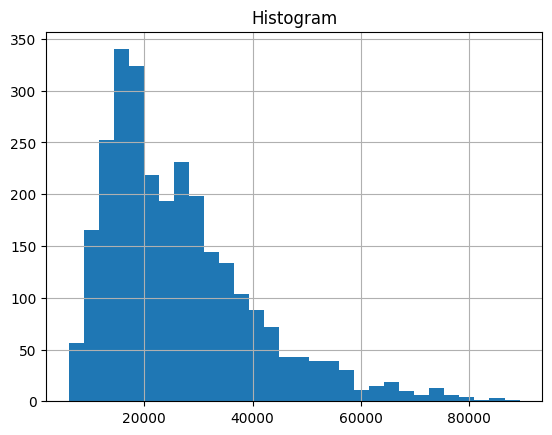

In [9]:
almondDataFrame['Area'].hist(bins=30)
plt.title('Histogram')
plt.show()

## Counting of almond types

In [10]:
def countAlmondTypes(fileName):
    almondDataFrame = pd.read_csv(fileName)
    typeCounts = almondDataFrame['Type'].value_counts()
    print(f"Almond type counts in {fileName}:")
    print(typeCounts)
    print("\n")

countAlmondTypes('CSVs/LengthAndWidth.csv')
countAlmondTypes('CSVs/LengthAndThickness.csv')
countAlmondTypes('CSVs/WidthAndThickness.csv')

Almond type counts in CSVs/LengthAndWidth.csv:
Type
MAMRA      359
REGULAR    325
SANORA     320
Name: count, dtype: int64


Almond type counts in CSVs/LengthAndThickness.csv:
Type
SANORA     320
REGULAR    316
MAMRA      306
Name: count, dtype: int64


Almond type counts in CSVs/WidthAndThickness.csv:
Type
SANORA     303
REGULAR    286
MAMRA      268
Name: count, dtype: int64




# NN Preamble

## Seed setter

In [11]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed) 
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
        torch.backends.cudnn.deterministic = True 
        torch.backends.cudnn.benchmark = False  

## Dataset class

In [12]:
class Nuts(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        self.X = self.data.iloc[:, :-1].values  
        self.y = self.data.iloc[:, -1].values  

        # Standardize the features
        #self.scaler = StandardScaler()
        #self.X = self.scaler.fit_transform(self.X)
        
        
        self.label_encoder = LabelEncoder()
        self.y = self.label_encoder.fit_transform(self.y) 
        
        
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.long) 
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# NN Classes

## Width and Thickness

In [13]:
class WidthAndThicknessNNClass(nn.Module):
    def __init__(self, input_size, num_classes):
        super(WidthAndThicknessNNClass, self).__init__()
        self.l1 = nn.Linear(input_size, 18)
        self.l2 = nn.Linear(18,10)
        self.l3 = nn.Linear(10, 10)
        self.l4 = nn.Linear(10, num_classes)
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        x = self.tanh(self.l1(x))
        x = self.tanh(self.l2(x))
        x = self.tanh(self.l3(x))
        x = self.l4(x)
        return x

## Length and Thickness

In [14]:

class LengthAndThicknessNNClass(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LengthAndThicknessNNClass, self).__init__()
        self.l1 = nn.Linear(input_size, 18)
        self.l2 = nn.Linear(18,10)
        self.l3 = nn.Linear(10, 10)
        self.l4 = nn.Linear(10, num_classes)
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        x = self.tanh(self.l1(x))
        x = self.tanh(self.l2(x))
        x = self.tanh(self.l3(x))
        x = self.l4(x)
        return x

## Length and Width

In [15]:
class LengthAndWidthNNClass(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LengthAndWidthNNClass, self).__init__()
        self.l1 = nn.Linear(input_size, 18)
        self.l2 = nn.Linear(18,10)
        self.l3 = nn.Linear(10, 10)
        self.l4 = nn.Linear(10, num_classes)
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        x = self.tanh(self.l1(x))
        x = self.tanh(self.l2(x))
        x = self.tanh(self.l3(x))
        x = self.l4(x)
        return x

# NN Creation Functions

## Width and Thickness

In [29]:
def WidthAndThicknessNN(trainingBatchSize = 32, testingBatchSize = 32, NNClass = WidthAndThicknessNNClass, numEpochs = 100, learningRate = 0.01, seed = 0, makeGraphs = True, output = True):
    set_seed(seed)
    train_dataset = Nuts("./CSVs/WidthAndThicknessWithoutColumnsTrainingNormalized.csv")
    test_dataset = Nuts("./CSVs/WidthAndThicknessWithoutColumnsTestingNormalized.csv")
    train_loader = DataLoader(train_dataset, batch_size=trainingBatchSize, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=testingBatchSize, shuffle=False)
    input_size = train_dataset.X.shape[1]
    model = NNClass(input_size=input_size, num_classes=3)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learningRate)
    
    train_losses = []
    train_accuracies = []
    
    if output:
        print("Training:")
        
    for epoch in range(numEpochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1) 
            total += labels.size(0)  
            correct += (predicted == labels).sum().item() 
        
        
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        if output:
            print(f"Epoch [{epoch+1}/{numEpochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
    if output:        
        print("Testing:")
        
    model.eval()
    all_preds = []
    all_labels = []
    running_loss = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    epoch_loss = running_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)

    accuracy = accuracy_score(all_labels, all_preds)
    
    if makeGraphs:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        
        ax1.plot(range(1, numEpochs + 1), train_losses, marker='o', color='b', label='Training Loss')
        ax1.set_title('Training Loss per Epoch')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid()

        ax2.plot(range(1, numEpochs + 1), train_accuracies, marker='o', color='g', label='Training Accuracy')
        ax2.set_title('Training Accuracy per Epoch')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid()

        plt.tight_layout()
        plt.savefig('WT_training_loss_accuracy.png')
        plt.show() 
    
    if output:
        print(f'Test Loss: {epoch_loss:.4f}')
        print(f'Test Accuracy: {accuracy:.4f}')
        
    return model, train_accuracies, train_losses, accuracy, epoch_loss


## Length and Thickness

In [30]:
def LengthAndThicknessNN(trainingBatchSize = 32, testingBatchSize = 32, NNClass = LengthAndThicknessNNClass, numEpochs = 100, learningRate = 0.01, seed = 0, makeGraphs = True, output = True):
    set_seed(seed)
    train_dataset = Nuts("./CSVs/LengthAndThicknessWithoutColumnsTrainingNormalized.csv")
    test_dataset = Nuts("./CSVs/LengthAndThicknessWithoutColumnsTestingNormalized.csv")
    train_loader = DataLoader(train_dataset, batch_size=trainingBatchSize, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=testingBatchSize, shuffle=False)
    input_size = train_dataset.X.shape[1]
    model = NNClass(input_size=input_size, num_classes=3)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learningRate)
    
    train_losses = []
    train_accuracies = []
    
    if output:
        print("Training:")
        
    for epoch in range(numEpochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            
            _, predicted = torch.max(outputs, 1)  
            total += labels.size(0)  
            correct += (predicted == labels).sum().item() 
        
        
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        
        if output:
            print(f"Epoch [{epoch+1}/{numEpochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
        
    if output:    
        print("Testing:")
        
    model.eval()
    all_preds = []
    all_labels = []
    running_loss = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    epoch_loss = running_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    
    if output:
        print(f'Test Loss: {epoch_loss:.4f}')
        print(f'Test Accuracy: {accuracy:.4f}')
    
    if makeGraphs:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        
        ax1.plot(range(1, numEpochs + 1), train_losses, marker='o', color='b', label='Training Loss')
        ax1.set_title('Training Loss per Epoch')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid()

        
        ax2.plot(range(1, numEpochs + 1), train_accuracies, marker='o', color='g', label='Training Accuracy')
        ax2.set_title('Training Accuracy per Epoch')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid()

        
        plt.tight_layout()
        plt.savefig('LT_training_loss_accuracy.png')
        plt.show() 
    
    return model, train_accuracies, train_losses, accuracy, epoch_loss


## Length and Width

In [31]:
def LengthAndWidthNN(trainingBatchSize = 32, testingBatchSize = 32, NNClass = LengthAndWidthNNClass, numEpochs = 100, learningRate = 0.01, seed = 0, makeGraphs = True, output = True):
    set_seed(seed)
    train_dataset = Nuts("./CSVs/LengthAndWidthWithoutColumnsTrainingNormalized.csv")
    test_dataset = Nuts("./CSVs/LengthAndWidthWithoutColumnsTestingNormalized.csv")
    train_loader = DataLoader(train_dataset, batch_size=trainingBatchSize, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=testingBatchSize, shuffle=False)
    input_size = train_dataset.X.shape[1]
    model = NNClass(input_size=input_size, num_classes=3)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learningRate)
    
    train_losses = []
    train_accuracies = []
    
    if output:
        print("Training:")
        
    for epoch in range(numEpochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (inputs, labels) in enumerate(train_loader):
            
            optimizer.zero_grad()
            
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0) 
            correct += (predicted == labels).sum().item()
        
        
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        if output:
            print(f"Epoch [{epoch+1}/{numEpochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
            
    if output:
        print("Testing:")
        
    model.eval()
    all_preds = []
    all_labels = []
    running_loss = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    epoch_loss = running_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    
    if makeGraphs:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        
        ax1.plot(range(1, numEpochs + 1), train_losses, marker='o', color='b', label='Training Loss')
        ax1.set_title('Training Loss per Epoch')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid()

        ax2.plot(range(1, numEpochs + 1), train_accuracies, marker='o', color='g', label='Training Accuracy')
        ax2.set_title('Training Accuracy per Epoch')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid()

        
        plt.tight_layout()
        plt.savefig('LW_training_loss_accuracy.png')
        plt.show()
    
    if output:
        print(f'Test Accuracy: {accuracy:.4f}')
        print(f'Test Loss: {epoch_loss:.4f}')
    return model, train_accuracies, train_losses, accuracy, epoch_loss


# Initial model experimentation

## Running the models

In [ ]:
WidthAndThicknessModel, wtAcc, wtLoss, wtFinalAcc, wtFinalLoss = WidthAndThicknessNN(numEpochs=1000, learningRate=0.1, seed=994) #[8697, 9721, 4934, 7467, 994]

In [ ]:
LengthAndThicknessModel, ltAcc, ltLoss, ltFinalAcc, ltFinalLoss = LengthAndThicknessNN(numEpochs=1000, learningRate=0.05, seed=994)

In [ ]:
LengthAndWidthModel, lwAcc, lwLoss, lwFinalAcc, lwFinalLoss = LengthAndWidthNN(numEpochs=500, learningRate=0.05, seed=8697)

## Results

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
# Plot loss
ax1.plot(range(1, len(wtLoss) + 1), wtLoss, marker='o', color='b', label='Width and Thiccness Training Loss')
ax1.plot(range(1, len(ltLoss) + 1), ltLoss, marker='+', color='r', label='Length and Thiccness Training Loss')
ax1.plot(range(1, len(lwLoss) + 1), lwLoss, marker='*', color='g', label='Length and Width Training Loss')
ax1.set_title('Training Loss per Epoch')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid()

# Plot accuracy
ax2.plot(range(1, len(wtAcc) + 1), wtAcc, marker='o', color='b', label='Width and Thiccness Training Accuracy')
ax2.plot(range(1, len(ltAcc) + 1), ltAcc, marker='+', color='r', label='Length and Thiccness Training Accuracy')
ax2.plot(range(1, len(lwAcc) + 1), lwAcc, marker='*', color='g', label='Length and Width Training Accuracy')
ax2.set_title('Training Accuracy per Epoch')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid()

# Save the figure
plt.tight_layout()
plt.savefig('NN_training_loss_accuracy.png')
plt.show()  # Show the plots in the notebook

In [ ]:
# Example values
values = [wtFinalAcc, ltFinalAcc, lwFinalAcc]  # Replace with your values
labels = ['Width and Thickness', 'Length and Thickness', 'Length and Width']  # Labels for the values

# Create a histogram
plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=['blue', 'red', 'green'], alpha=0.7)  # Bar chart to represent histogram
plt.title('Final training accuracies for different NN models')
plt.xlabel('NN Models')
plt.ylabel('Accuracy (%)')
plt.grid(axis='y')  # Add gridlines only for the y-axis
plt.show()  # Display the plot

# Grid Search

## Single run grid search

In [19]:
def gridSearch(modelFunction, epochs, learningRates, seed, testing=True, makeGraphs=True, output=True):
    accuracies = []
    losses = []
    max = len(epochs) * len(learningRates)
    count = 1
    for epoch in epochs:
        epochAcc = []
        epochLoss = []
        for lr in learningRates:
            if output:
                print(
                    "[{}/{}] Starting with training using a learning rate of {} for {} epochs".format(count, max, lr, epoch))
            model, trainingAcc, trainingLoss, testingAcc, testingLoss = modelFunction(
                numEpochs=epoch, learningRate=lr, seed=seed, makeGraphs=False, output=False)
            if output:
                print(
                    "[{}/{}] Finished with training using a learning rate of {} for {} epochs\n".format(count, max, lr, epoch))
            count += 1
            if testing:
                epochAcc += [testingAcc]
                epochLoss += [testingLoss]
            else:
                epochAcc += [trainingAcc[-1]]
                epochLoss += [trainingLoss[-1]]

        accuracies += [epochAcc]
        losses += [epochLoss]

    if makeGraphs:
        plt.figure(figsize=(20, 20))
        plt.subplot(1, 2, 1)
        plt.imshow(accuracies, interpolation='nearest', cmap="RdYlGn")
        plt.title('Accuracy')
        plt.xlabel('Learning rate')
        plt.ylabel('Number of epochs')

        if testing:
            plt.colorbar(label='Test Accuracy')
        else:
            plt.colorbar(label='Training Accuracy')

        plt.xticks(np.arange(len(learningRates)), labels=learningRates)
        plt.yticks(np.arange(len(epochs)), labels=epochs)

        for i in range(len(epochs)):
            for j in range(len(learningRates)):
                plt.text(j, i, f'{accuracies[i][j]:.5f}',
                         ha='center', va='center', color='black')

        
        plt.subplot(1, 2, 2)
        plt.imshow(losses, interpolation='nearest', cmap="coolwarm")
        plt.title('Loss')
        plt.xlabel('Learning rate')
        plt.ylabel('Number of epochs')

        if testing:
            plt.colorbar(label='Test Loss')
        else:
            plt.colorbar(label='Training Loss')

        plt.xticks(np.arange(len(learningRates)), labels=learningRates)
        plt.yticks(np.arange(len(epochs)), labels=epochs)

        for i in range(len(epochs)):
            for j in range(len(learningRates)):
                plt.text(j, i, f'{losses[i][j]:.5f}',
                         ha='center', va='center', color='black')

        plt.tight_layout()
        plt.show()
        
    return accuracies, losses

In [20]:
#gridSearch(WidthAndThicknessNN, [1,10,100,200], [10, 1, 0.1, 0.01, 0.001], 0)

## Multi run grid search

In [36]:
def ranges_overlap(range1, range2):
    start1, end1 = range1
    start2, end2 = range2
    
    if(start1 >= start2 and start1 <= end2) or (end1 >= start2 and end1 <= end2) or (start2 >= start1 and start2 <= end1) or (end2 >= start1 and end2 <= end2):
        return True
    return False

In [22]:
def multipleGridSearches(modelFunction, epochs, learningRates, seeds, testing=True, makeGraphs=True, output=True, alpha = 0.01):
    accuracies = []
    losses = []
    finishedProcesses = 0
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(gridSearch, modelFunction, epochs, learningRates, seed, testing, False, False)
            for seed in seeds
        ]
        for future in concurrent.futures.as_completed(futures):
            finishedProcesses += 1
            print("[{}/{}] finished running".format(finishedProcesses, len(seeds)))
            acc, loss = future.result()
            accuracies.append(acc)
            losses.append(loss)
    
    # for seed in seeds:
    #     finishedProcesses += 1
    #     print("[{}/{}] started running".format(finishedProcesses, len(seeds)))
    #     acc, loss = gridSearch(modelFunction, epochs, learningRates, seed, testing, False, False)
    #     accuracies.append(acc)
    #     losses.append(loss)
    
        
    accs = {}
    losss = {}
        
    for i in range(0,len(accuracies)):
        for j in range(0,len(accuracies[i])):
            if not j in accs:
                accs[j] = {}
                losss[j] = {}
                
            for k in range(0,len(accuracies[j])):
                if not k in accs[j]:
                    accs[j][k] = []
                    losss[j][k] = []
                    
                accs[j][k] += [accuracies[i][j][k]]
                losss[j][k] += [losses[i][j][k]]
        
    avgAcc = np.zeros((len(epochs), len(learningRates)))
    stdAcc = np.zeros((len(epochs), len(learningRates)))
    avgLoss = np.zeros((len(epochs), len(learningRates)))
    stdLoss = np.zeros((len(epochs), len(learningRates)))
        
    bestAcc = {
        "i" : 0,
        "j" : 0,
        "acc": -1,
        "std": 0
    }
    bestLoss = {
        "i" : 0,
        "j" : 0,
        "loss": 10000000000,
        "std": 0
    }
        
    for i in accs.keys():
        for j in accs[i].keys():
            avgAcc[i][j] = stats.mean(accs[i][j])
            stdAcc[i][j] = stats.stdev(accs[i][j])
            avgLoss[i][j] = stats.mean(losss[i][j])
            stdLoss[i][j] = stats.stdev(losss[i][j])
            if(avgAcc[i][j] > bestAcc["acc"]):
                bestAcc["i"] = i
                bestAcc["j"] = j
                bestAcc["acc"] = avgAcc[i][j]
                bestAcc["std"] = stdAcc[i][j]
                
            if(avgLoss[i][j] < bestLoss["loss"]):
                bestLoss["i"] = i
                bestLoss["j"] = j
                bestLoss["loss"] = avgLoss[i][j]
                bestLoss["std"] = stdLoss[i][j]
            
    bestAccRange = [bestAcc["acc"] - bestAcc["std"], bestAcc["acc"] + bestAcc["std"]]    
    bestLossRange = [bestLoss["loss"] - bestLoss["std"], bestLoss["loss"] + bestLoss["std"]]       
    
    accOverlaps = []
    lossOverlaps = []
        
    for i in range(0, len(avgAcc)):
        for j in range(0, len(avgAcc[i])):
            if bestAcc["i"] != i and bestAcc["j"] != j:
                currAccRange = [avgAcc[i][j] - stdAcc[i][j], avgAcc[i][j] + stdAcc[i][j]]
                if ranges_overlap(bestAccRange, currAccRange):
                    accOverlaps += [(i,j)]
                    
            if bestLoss["i"] != i and bestLoss["j"] != j:
                currLossRange = [avgLoss[i][j] - stdLoss[i][j], avgLoss[i][j] + stdLoss[i][j]]
                if ranges_overlap(bestLossRange, currLossRange):
                    lossOverlaps += [(i,j)]
                    
    if(bestAcc["i"] != bestLoss["i"] or bestAcc["j"]  !=  bestLoss["j"]):
        accOverlaps += [(bestLoss["i"], bestLoss["j"])]
        lossOverlaps += [(bestAcc["i"], bestAcc["j"])]
    
    if len(accOverlaps) > 0 or len(lossOverlaps) > 0:
        bestSample = accs[bestAcc["i"]][bestAcc["j"]]
        for olap in accOverlaps:
            i, j = olap
            otherSample = accs[i][j]
            t_stat, p_value = ttest_ind(bestSample, otherSample)
            if p_value < alpha:
                print("The difference in accuracy performance between {} and {} is statistically significant using a {} confidence.".format(bestAcc["acc"], avgAcc[i][j], 1-alpha))
            else:
                print("The difference in accuracy performance between {} and {} is not statistically significant using a {} confidence.".format(bestAcc["acc"], avgAcc[i][j], 1-alpha))

        bestSample = losss[bestLoss["i"]][bestLoss["j"]]
        for olap in lossOverlaps:
            i, j = olap
            otherSample = losss[i][j]
            t_stat, p_value = ttest_ind(bestSample, otherSample)
            if p_value < alpha:
                print("The difference in loss performance between {} and {} is statistically significant using a {} confidence.".format(bestLoss["loss"], avgLoss[i][j], 1-alpha))
            else:
                print("The difference in loss performance between {} and {} is not statistically significant using a {} confidence.".format(bestLoss["loss"], avgLoss[i][j], 1-alpha))
    else:            
        print("Best is the hp with an acc of {} and a loss of {}".format(bestAcc["acc"], bestLoss["loss"]))
            
    if makeGraphs:
        plt.figure(figsize=(10, 10))
        plt.imshow(avgAcc, interpolation='nearest', cmap="RdYlGn")
        plt.title('Accuracy')
        plt.xlabel('Learning rate')
        plt.ylabel('Number of epochs')

        if testing:
            plt.colorbar(label='Test Accuracy', shrink = 0.5)
        else:
            plt.colorbar(label='Training Accuracy')

        plt.xticks(np.arange(len(learningRates)), labels=learningRates)
        plt.yticks(np.arange(len(epochs)), labels=epochs)

        for i in range(len(epochs)):
            for j in range(len(learningRates)):
                plt.text(j, i, "{} ({})".format(round(avgAcc[i][j],5), round(stdAcc[i][j], 5)),
                         ha='center', va='center', color='black')
        plt.tight_layout()
        plt.show()

        
        plt.figure(figsize=(10, 10))
        plt.imshow(avgLoss, interpolation='nearest', cmap="coolwarm")
        plt.title('Loss')
        plt.xlabel('Learning rate')
        plt.ylabel('Number of epochs')

        if testing:
            plt.colorbar(label='Test Loss', shrink=0.5)
        else:
            plt.colorbar(label='Training Loss')

        plt.xticks(np.arange(len(learningRates)), labels=learningRates)
        plt.yticks(np.arange(len(epochs)), labels=epochs)

        for i in range(len(epochs)):
            for j in range(len(learningRates)):
                plt.text(j, i, "{} ({})".format(round(avgLoss[i][j],5), round(stdLoss[i][j], 5)),
                         ha='center', va='center', color='black')

        plt.tight_layout()
        plt.show()
        
    return accs, losss

## Results

In [ ]:
multipleGridSearches(LengthAndWidthNN, [1,10,100,200], [1,0.1,0.01, 0.005, 0.001], [0,1,2,3,4])

In [ ]:
multipleGridSearches(LengthAndWidthNN, [1,10,100,200], [1,0.1,0.01,0.001], [0,1,2,3,4], alpha = 0.05)

In [ ]:
multipleGridSearches(LengthAndThicknessNN, [1,10,100,200], [1,0.1,0.01,0.001], [0,1,2,3,4])

In [ ]:
multipleGridSearches(LengthAndThicknessNN, [1,10,100,200], [1,0.1,0.01,0.001], [0,1,2,3,4], testing=False)

# Rprop Creation Functions

## Width and Thickness

In [23]:
def RPropWidthAndThicknessNN(trainingBatchSize = 32, testingBatchSize = 32, NNClass = WidthAndThicknessNNClass, numEpochs = 100, learningRate = 0.01, seed = 0, makeGraphs = True, output = True):
    set_seed(seed)
    train_dataset = Nuts("./CSVs/WidthAndThicknessWithoutColumnsTrainingNormalized.csv")
    test_dataset = Nuts("./CSVs/WidthAndThicknessWithoutColumnsTestingNormalized.csv")
    train_loader = DataLoader(train_dataset, batch_size=trainingBatchSize, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=testingBatchSize, shuffle=False)
    input_size = train_dataset.X.shape[1]
    model = NNClass(input_size=input_size, num_classes=3)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Rprop(model.parameters(), lr=learningRate)
    
    train_losses = []
    train_accuracies = []
    
    if output:
        print("Training:")
        
    for epoch in range(numEpochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (inputs, labels) in enumerate(train_loader):
            
            optimizer.zero_grad()
            
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        if output:
            print(f"Epoch [{epoch+1}/{numEpochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
    if output:        
        print("Testing:")
        
    model.eval()
    all_preds = []
    all_labels = []
    running_loss = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = accuracy_score(all_labels, all_preds)

    accuracy = accuracy_score(all_labels, all_preds)
    
    if makeGraphs:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        
        ax1.plot(range(1, numEpochs + 1), train_losses, marker='o', color='b', label='Training Loss')
        ax1.set_title('Training Loss per Epoch')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid()

        
        ax2.plot(range(1, numEpochs + 1), train_accuracies, marker='o', color='g', label='Training Accuracy')
        ax2.set_title('Training Accuracy per Epoch')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid()

        
        plt.tight_layout()
        plt.savefig('WT_training_loss_accuracy.png')
        plt.show()
    
    if output:
        print(f'Test Loss: {epoch_loss:.4f}')
        print(f'Test Accuracy: {accuracy:.4f}')
        
    return model, train_accuracies, train_losses, accuracy, epoch_loss


## Length and Thickness

In [24]:
def RpropLengthAndThicknessNN(trainingBatchSize = 32, testingBatchSize = 32, NNClass = LengthAndThicknessNNClass, numEpochs = 100, learningRate = 0.01, seed = 0, makeGraphs = True, output = True):
    set_seed(seed)
    train_dataset = Nuts("./CSVs/LengthAndThicknessWithoutColumnsTrainingNormalized.csv")
    test_dataset = Nuts("./CSVs/LengthAndThicknessWithoutColumnsTestingNormalized.csv")
    train_loader = DataLoader(train_dataset, batch_size=trainingBatchSize, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=testingBatchSize, shuffle=False)
    input_size = train_dataset.X.shape[1]
    model = NNClass(input_size=input_size, num_classes=3)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Rprop(model.parameters(), lr=learningRate)
    
    train_losses = []
    train_accuracies = []
    
    if output:
        print("Training:")
        
    for epoch in range(numEpochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (inputs, labels) in enumerate(train_loader):
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        
        if output:
            print(f"Epoch [{epoch+1}/{numEpochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
        
    if output:    
        print("Testing:")
        
    model.eval()
    all_preds = []
    all_labels = []
    running_loss = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    
    if output:
        print(f'Test Loss: {epoch_loss:.4f}')
        print(f'Test Accuracy: {accuracy:.4f}')
    
    if makeGraphs:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        
        ax1.plot(range(1, numEpochs + 1), train_losses, marker='o', color='b', label='Training Loss')
        ax1.set_title('Training Loss per Epoch')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid()

        
        ax2.plot(range(1, numEpochs + 1), train_accuracies, marker='o', color='g', label='Training Accuracy')
        ax2.set_title('Training Accuracy per Epoch')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid()

        
        plt.tight_layout()
        plt.savefig('LT_training_loss_accuracy.png')
        plt.show()
    
    return model, train_accuracies, train_losses, accuracy, epoch_loss


## Length and Width

In [25]:
def RPropLengthAndWidthNN(trainingBatchSize = 32, testingBatchSize = 32, NNClass = LengthAndWidthNNClass, numEpochs = 100, learningRate = 0.01, seed = 0, makeGraphs = True, output = True):
    set_seed(seed)
    train_dataset = Nuts("./CSVs/LengthAndWidthWithoutColumnsTrainingNormalized.csv")
    test_dataset = Nuts("./CSVs/LengthAndWidthWithoutColumnsTestingNormalized.csv")
    train_loader = DataLoader(train_dataset, batch_size=trainingBatchSize, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=testingBatchSize, shuffle=False)
    input_size = train_dataset.X.shape[1]
    model = NNClass(input_size=input_size, num_classes=3)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Rprop(model.parameters(), lr=learningRate)
    
    train_losses = []
    train_accuracies = []
    
    if output:
        print("Training:")
        
    for epoch in range(numEpochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (inputs, labels) in enumerate(train_loader):
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            # Calculate predictions and accuracy
            _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
            total += labels.size(0)  # Total number of labels
            correct += (predicted == labels).sum().item()  # Correct predictions
        
        # Calculate loss and accuracy
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        if output:
            print(f"Epoch [{epoch+1}/{numEpochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
            
    if output:
        print("Testing:")
        
    model.eval()
    all_preds = []
    all_labels = []
    running_loss = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    
    if makeGraphs:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        # Plot loss
        ax1.plot(range(1, numEpochs + 1), train_losses, marker='o', color='b', label='Training Loss')
        ax1.set_title('Training Loss per Epoch')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid()

        # Plot accuracy
        ax2.plot(range(1, numEpochs + 1), train_accuracies, marker='o', color='g', label='Training Accuracy')
        ax2.set_title('Training Accuracy per Epoch')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid()

        # Save the figure
        plt.tight_layout()
        plt.savefig('LW_training_loss_accuracy.png')
        plt.show()  # Show the plots in the notebook
    
    if output:
        print(f'Test Accuracy: {accuracy:.4f}')
        print(f'Test Loss: {epoch_loss:.4f}')
    return model, train_accuracies, train_losses, accuracy, epoch_loss

## Running the models

In [ ]:
RPropWidthAndThicknessModel, wtAcc, wtLoss, wtFinalAcc, wtFinalLoss = RPropWidthAndThicknessNN()

In [ ]:
RPropLengthAndThicknessModel, ltAcc, ltLoss, ltFinalAcc, ltFinalLoss = RpropLengthAndThicknessNN()

In [ ]:
RPropLengthAndWidthModel, lwAcc, lwLoss, lwFinalAcc, lwFinalLoss = RPropLengthAndWidthNN()

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
# Plot loss
ax1.plot(range(1, len(wtLoss) + 1), wtLoss, marker='o', color='b', label='Width and Thiccness Training Loss')
ax1.plot(range(1, len(ltLoss) + 1), ltLoss, marker='+', color='r', label='Length and Thiccness Training Loss')
ax1.plot(range(1, len(lwLoss) + 1), lwLoss, marker='*', color='g', label='Length and Width Training Loss')
ax1.set_title('Training Loss per Epoch')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid()

# Plot accuracy
ax2.plot(range(1, len(wtAcc) + 1), wtAcc, marker='o', color='b', label='Width and Thiccness Training Accuracy')
ax2.plot(range(1, len(ltAcc) + 1), ltAcc, marker='+', color='r', label='Length and Thiccness Training Accuracy')
ax2.plot(range(1, len(lwAcc) + 1), lwAcc, marker='*', color='g', label='Length and Width Training Accuracy')
ax2.set_title('Training Accuracy per Epoch')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid()

# Save the figure
plt.tight_layout()
plt.savefig('NN_training_loss_accuracy.png')
plt.show()  # Show the plots in the notebook

In [ ]:
# Example values
values = [wtFinalAcc, ltFinalAcc, lwFinalAcc]  # Replace with your values
labels = ['Width and Thickness', 'Length and Thickness', 'Length and Width']  # Labels for the values

# Create a histogram
plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=['blue', 'red', 'green'], alpha=0.7)  # Bar chart to represent histogram
plt.title('Final training accuracies for different NN models')
plt.xlabel('NN Models')
plt.ylabel('Accuracy (%)')
plt.grid(axis='y')  # Add gridlines only for the y-axis
plt.show()  # Display the plot

# Experiments

## Normal Grid Search

### Length and Width

[1/5] finished running
[2/5] finished running
[3/5] finished running
[4/5] finished running
[5/5] finished running
The difference in accuracy performance between 0.5820512820512821 and 0.5371794871794872 is not statistically significant using a 0.95 confidence.
The difference in accuracy performance between 0.5820512820512821 and 0.5756410256410256 is not statistically significant using a 0.95 confidence.
The difference in accuracy performance between 0.5820512820512821 and 0.5435897435897437 is statistically significant using a 0.95 confidence.
The difference in accuracy performance between 0.5820512820512821 and 0.532051282051282 is not statistically significant using a 0.95 confidence.
The difference in accuracy performance between 0.5820512820512821 and 0.533974358974359 is statistically significant using a 0.95 confidence.
The difference in loss performance between 0.8984565937519073 and 1.043098100423813 is statistically significant using a 0.95 confidence.
The difference in loss

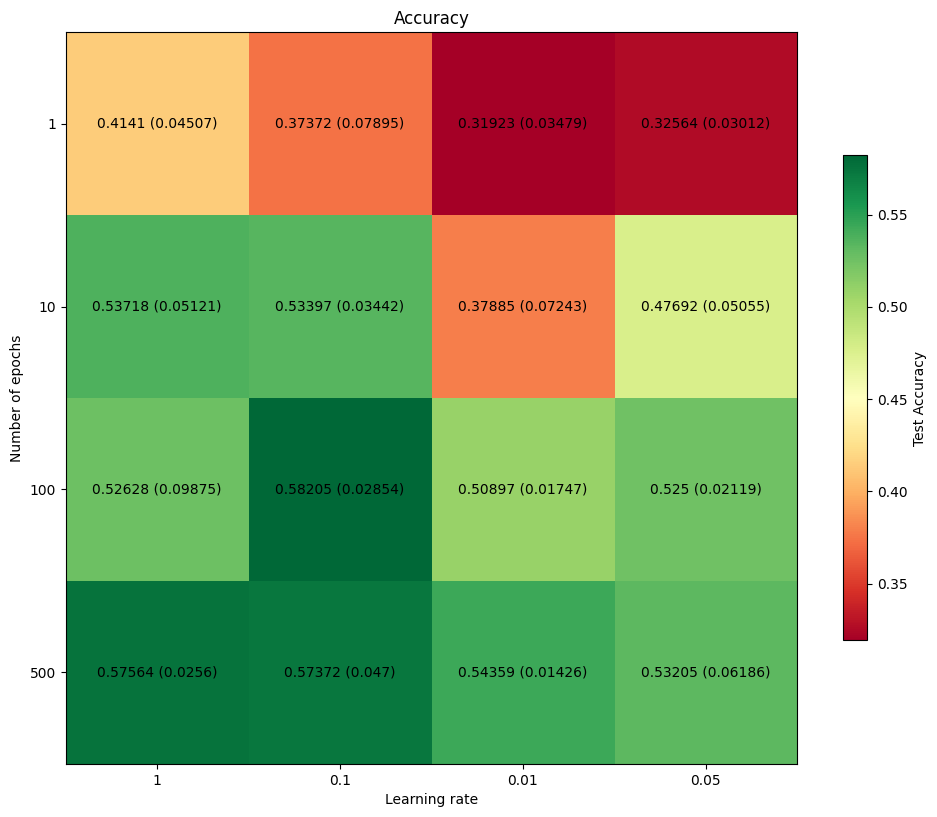

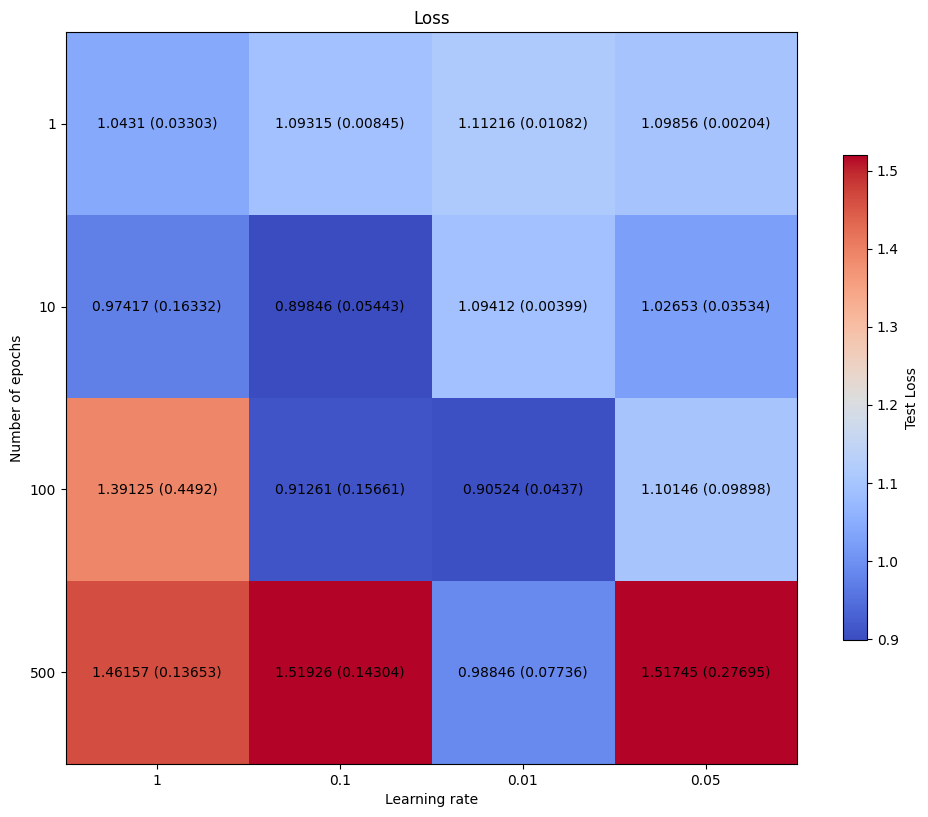

({0: {0: [0.3782051282051282,
    0.3814102564102564,
    0.42628205128205127,
    0.48717948717948717,
    0.3974358974358974],
   1: [0.3782051282051282,
    0.32371794871794873,
    0.3525641025641026,
    0.3076923076923077,
    0.5064102564102564],
   2: [0.2980769230769231,
    0.3782051282051282,
    0.32371794871794873,
    0.2980769230769231,
    0.2980769230769231],
   3: [0.3076923076923077,
    0.3782051282051282,
    0.3108974358974359,
    0.3076923076923077,
    0.32371794871794873]},
  1: {0: [0.6153846153846154,
    0.5096153846153846,
    0.5384615384615384,
    0.5448717948717948,
    0.4775641025641026],
   1: [0.5865384615384616,
    0.5160256410256411,
    0.5096153846153846,
    0.5064102564102564,
    0.5512820512820513],
   2: [0.3717948717948718,
    0.358974358974359,
    0.2980769230769231,
    0.3685897435897436,
    0.4967948717948718],
   3: [0.5,
    0.38782051282051283,
    0.49038461538461536,
    0.4935897435897436,
    0.5128205128205128]},
  2: {0: 

In [37]:
multipleGridSearches(LengthAndWidthNN, [1,10,100,500], [1,0.1,0.01, 0.05], [0,8697, 9721, 4934, 12345], alpha = 0.05)

### Length and Thickness

[1/5] finished running
[2/5] finished running
[3/5] finished running
[4/5] finished running
[5/5] finished running
The difference in accuracy performance between 0.7508532423208191 and 0.6853242320819113 is not statistically significant using a 0.95 confidence.
The difference in accuracy performance between 0.7508532423208191 and 0.7078498293515358 is not statistically significant using a 0.95 confidence.
The difference in accuracy performance between 0.7508532423208191 and 0.7064846416382252 is statistically significant using a 0.95 confidence.
The difference in loss performance between 0.5683330649137497 and 1.2491400276869535 is statistically significant using a 0.95 confidence.
The difference in loss performance between 0.5683330649137497 and 1.0901990044116974 is statistically significant using a 0.95 confidence.
The difference in loss performance between 0.5683330649137497 and 1.0937314867973327 is statistically significant using a 0.95 confidence.
The difference in loss performa

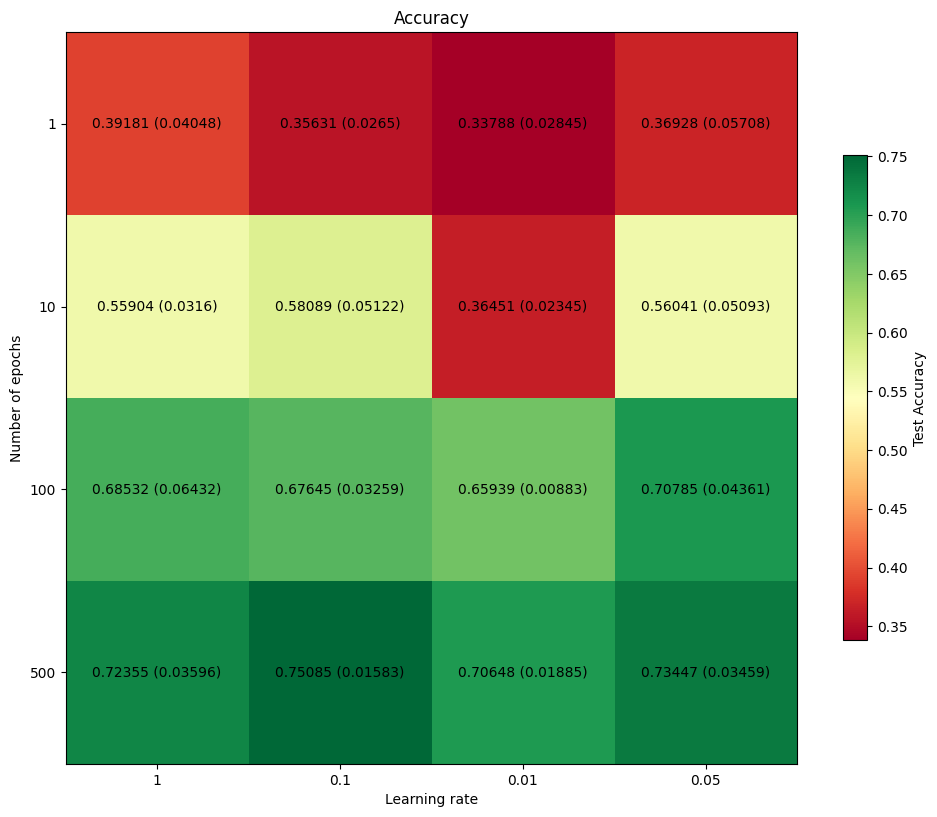

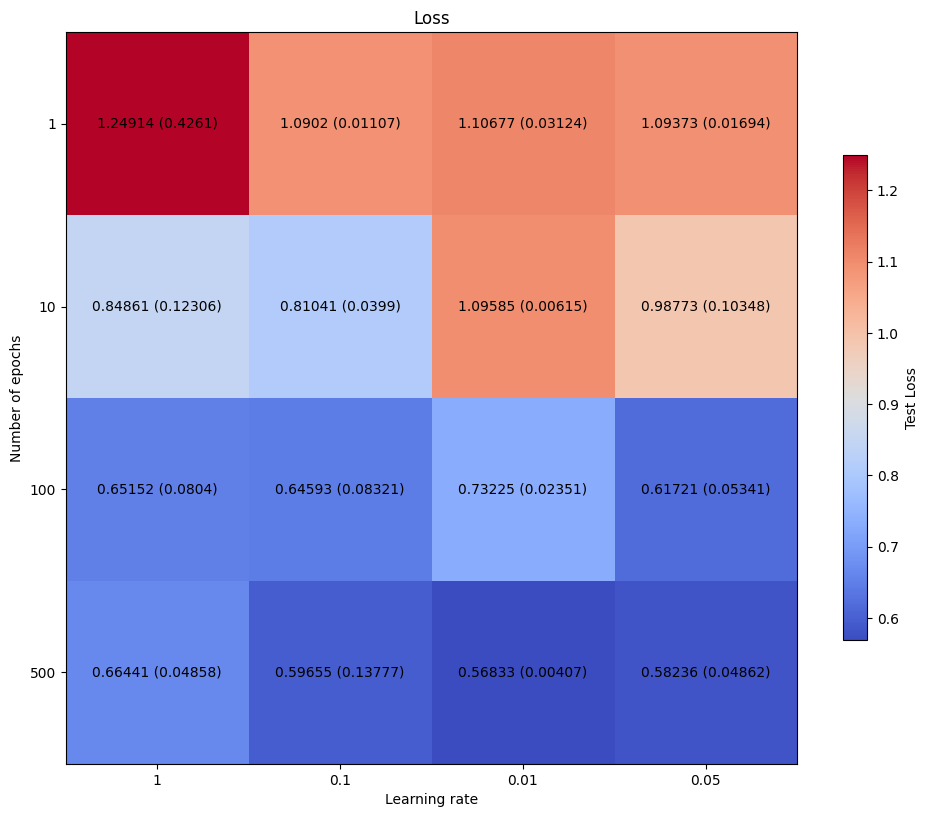

({0: {0: [0.37542662116040953,
    0.4300341296928328,
    0.4402730375426621,
    0.35494880546075086,
    0.3583617747440273],
   1: [0.3515358361774744,
    0.3412969283276451,
    0.40273037542662116,
    0.3378839590443686,
    0.34812286689419797],
   2: [0.3583617747440273,
    0.3583617747440273,
    0.31399317406143346,
    0.3003412969283277,
    0.3583617747440273],
   3: [0.3583617747440273,
    0.45733788395904434,
    0.3515358361774744,
    0.3003412969283277,
    0.378839590443686]},
  1: {0: [0.5699658703071673,
    0.5870307167235495,
    0.5836177474402731,
    0.5426621160409556,
    0.5119453924914675],
   1: [0.5358361774744027,
    0.5665529010238908,
    0.5597269624573379,
    0.5733788395904437,
    0.6689419795221843],
   2: [0.3583617747440273,
    0.3924914675767918,
    0.3856655290102389,
    0.3447098976109215,
    0.3412969283276451],
   3: [0.590443686006826,
    0.5938566552901023,
    0.590443686006826,
    0.47440273037542663,
    0.552901023890785]

In [38]:
multipleGridSearches(LengthAndThicknessNN, [1,10,100,500], [1,0.1,0.01, 0.05], [0,8697, 9721, 4934, 12345], alpha = 0.05)

### Width and Thickness

[1/5] finished running
[2/5] finished running
[3/5] finished running
[4/5] finished running
[5/5] finished running
The difference in accuracy performance between 0.6360902255639098 and 0.5593984962406016 is not statistically significant using a 0.95 confidence.
The difference in accuracy performance between 0.6360902255639098 and 0.6120300751879699 is not statistically significant using a 0.95 confidence.
The difference in accuracy performance between 0.6360902255639098 and 0.6293233082706767 is not statistically significant using a 0.95 confidence.
The difference in loss performance between 0.9121553222338359 and 1.1238091323110793 is statistically significant using a 0.95 confidence.
The difference in loss performance between 0.9121553222338359 and 1.1318198495441012 is statistically significant using a 0.95 confidence.
The difference in loss performance between 0.9121553222338359 and 1.1082437303331163 is statistically significant using a 0.95 confidence.
The difference in loss perf

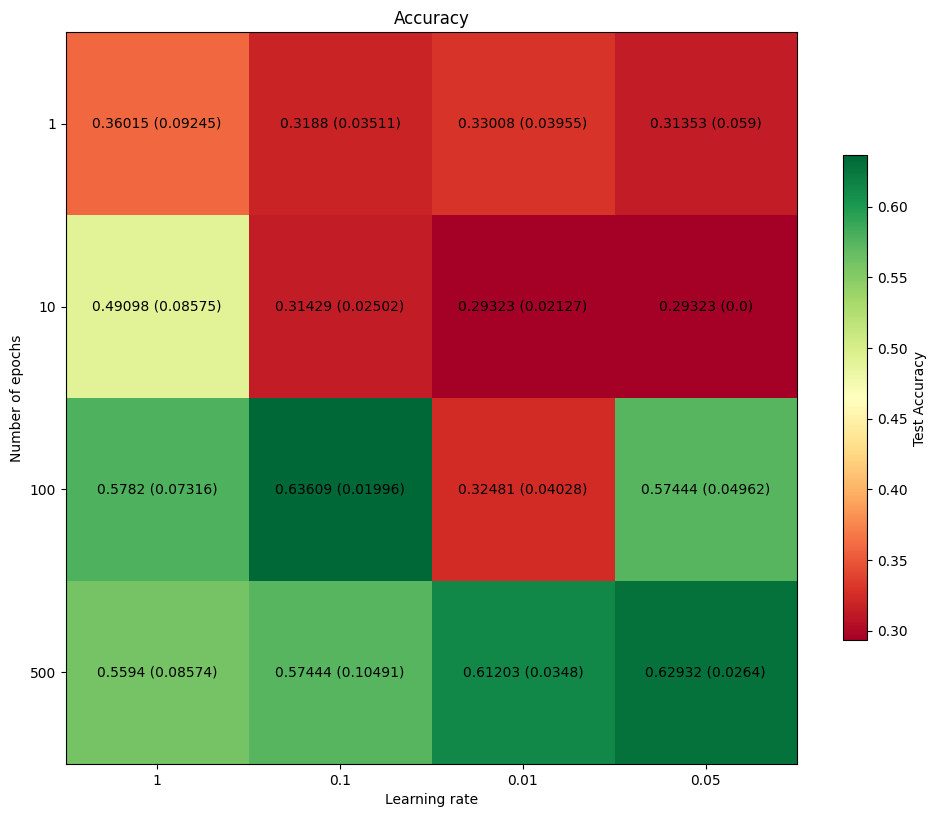

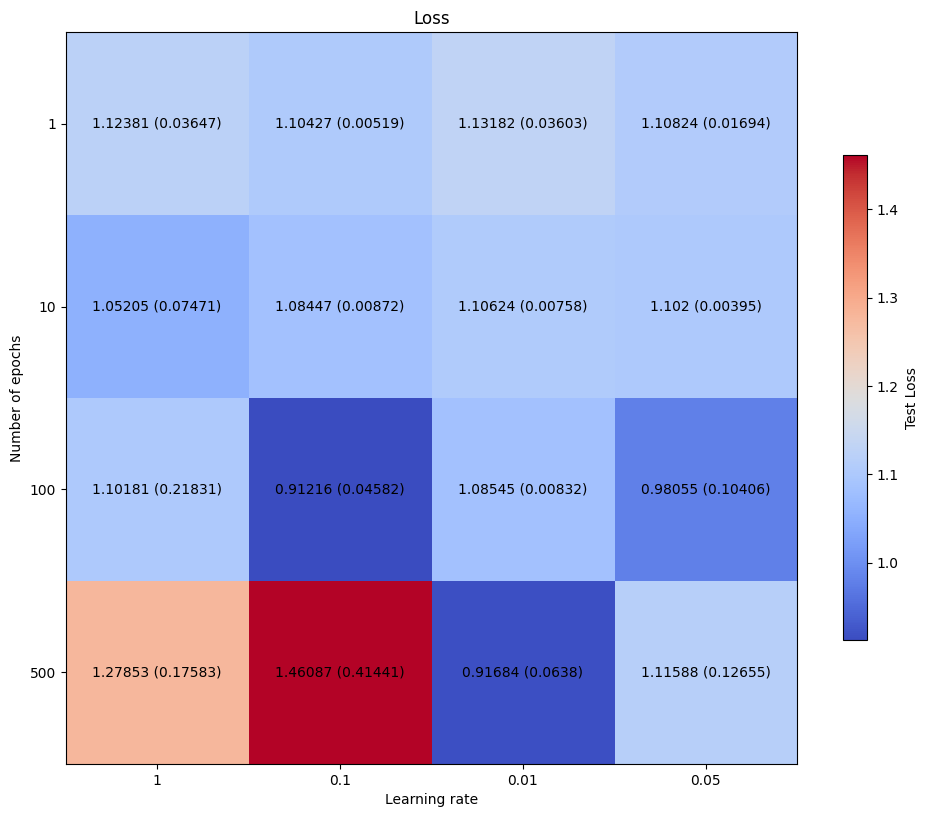

({0: {0: [0.31203007518796994,
    0.39473684210526316,
    0.2932330827067669,
    0.2932330827067669,
    0.5075187969924813],
   1: [0.2932330827067669,
    0.3533834586466165,
    0.2932330827067669,
    0.2932330827067669,
    0.3609022556390977],
   2: [0.2932330827067669,
    0.39473684210526316,
    0.31203007518796994,
    0.31203007518796994,
    0.3383458646616541],
   3: [0.2932330827067669,
    0.23308270676691728,
    0.31203007518796994,
    0.39473684210526316,
    0.33458646616541354]},
  1: {0: [0.39097744360902253,
    0.4398496240601504,
    0.5225563909774437,
    0.6165413533834586,
    0.4849624060150376],
   1: [0.2932330827067669,
    0.30451127819548873,
    0.34962406015037595,
    0.3308270676691729,
    0.2932330827067669],
   2: [0.2932330827067669,
    0.2932330827067669,
    0.3233082706766917,
    0.2631578947368421,
    0.2932330827067669],
   3: [0.2932330827067669,
    0.2932330827067669,
    0.2932330827067669,
    0.2932330827067669,
    0.29323308

In [40]:
multipleGridSearches(WidthAndThicknessNN, [1, 10,100,500], [1,0.1,0.01, 0.05], [0,8697, 9721, 4934, 12345], alpha = 0.05)

## RProp experiments using the same best as obtained above

### Width and Thickness

In [ ]:
multipleGridSearches(RPropWidthAndThicknessNN, [1000], [0.01], [8697, 9721, 4934, 7467, 994], alpha = 0.05)

### Length and Thickness

In [ ]:
multipleGridSearches(RpropLengthAndThicknessNN, [1000], [0.01], [8697, 9721, 4934, 7467, 994], alpha = 0.05)

### Length and Width

In [ ]:
multipleGridSearches(RPropLengthAndWidthNN, [1000], [0.01], [8697, 9721, 4934, 7467, 994], alpha = 0.05)

# Hybrid Learning

## Creation functions

### Width and Thickness

In [64]:
def HTWidthAndThicknessNN(trainingBatchSize = 32, testingBatchSize = 32, NNClass = WidthAndThicknessNNClass, numEpochs = 100, learningRate = 0.01, seed = 0, makeGraphs = True, output = True, standardWeight=0.75, rpropWeight = 0.25):
    set_seed(seed)
    weightTotal = standardWeight + rpropWeight
    standardWeight = standardWeight/weightTotal
    rpropWeight = rpropWeight/weightTotal
    train_dataset = Nuts("./CSVs/WidthAndThicknessWithoutColumnsTrainingNormalized.csv")
    test_dataset = Nuts("./CSVs/WidthAndThicknessWithoutColumnsTestingNormalized.csv")
    train_loader = DataLoader(train_dataset, batch_size=trainingBatchSize, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=testingBatchSize, shuffle=False)
    input_size = train_dataset.X.shape[1]
    modelA = NNClass(input_size=input_size, num_classes=3)
    modelB = NNClass(input_size=input_size, num_classes=3)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(modelA.parameters(), lr=learningRate)
    rprop = optim.Rprop(modelB.parameters(), lr=learningRate)
    
    train_lossesA = []
    train_accuraciesA = []
    train_lossesB = []
    train_accuraciesB = []
    
    if output:
        print("Training:")
        
    for epoch in range(numEpochs):
        optimizer.zero_grad()
        rprop.zero_grad()
        
        modelA.train()
        modelB.train()
        running_lossA = 0.0
        running_lossB = 0.0
        correctA = 0
        correctB = 0
        total = 0
        
        for i, (inputs, labels) in enumerate(train_loader):
            
            optimizer.zero_grad()
            rprop.zero_grad()
            
            
            outputsA = modelA(inputs)
            outputsB = modelB(inputs)
            lossA = criterion(outputsA, labels)
            lossB = criterion(outputsB, labels)
            lossA.backward()
            lossB.backward()
            
            with torch.no_grad():
                for p1, p2, in zip(modelA.parameters(), modelB.parameters()):
                    grad1 = p1.grad
                    grad2 = p2.grad
                    avg = (standardWeight * grad1 + rpropWeight* grad2)/2
                    
                    p1.grad = avg
                    p2.grad = avg
                    
            optimizer.step()
            rprop.step()
            
            running_lossA += lossA.item()
            running_lossB += lossB.item()

            _, predictedA = torch.max(outputsA, 1)
            _, predictedB = torch.max(outputsB, 1)
            total += labels.size(0)
            correctA += (predictedA == labels).sum().item()
            correctB += (predictedB == labels).sum().item()
        
        
        epoch_lossA = running_lossA / len(train_loader)
        epoch_accuracyA = 100 * correctA / total
        epoch_lossB = running_lossB / len(train_loader)
        epoch_accuracyB = 100 * correctB / total
        
        train_lossesA.append(epoch_lossA)
        train_accuraciesA.append(epoch_accuracyA)
        train_lossesB.append(epoch_lossB)
        train_accuraciesB.append(epoch_accuracyB)

        if output:
            print(f"Standard: Epoch [{epoch+1}/{numEpochs}], Loss: {epoch_lossA:.4f}, Accuracy: {epoch_accuracyA:.2f}%")
            print(f"Prop: Epoch [{epoch+1}/{numEpochs}], Loss: {epoch_lossB:.4f}, Accuracy: {epoch_accuracyB:.2f}%")
    if output:        
        print("Testing:")
        
    modelA.eval()
    modelB.eval()
    all_predsA = []
    all_labelsA = []
    all_predsB = []
    all_labelsB = []
    running_lossA = 0
    running_lossB = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputsA = modelA(inputs)
            outputsB = modelB(inputs)
            _, predsA = torch.max(outputsA, 1)
            _, predsB = torch.max(outputsB, 1)
            all_predsA.extend(predsA.numpy())
            all_predsB.extend(predsB.numpy())
            all_labelsA.extend(labels.numpy())
            all_labelsB.extend(labels.numpy())
            lossA = criterion(outputsA, labels)
            lossB = criterion(outputsB, labels)
            running_lossA += lossA.item()
            running_lossB += lossB.item()

    epoch_lossA = running_lossA / len(test_loader)
    accuracyA = accuracy_score(all_labelsA, all_predsA)
    epoch_lossB = running_lossB / len(test_loader)
    accuracyB = accuracy_score(all_labelsB, all_predsB)
    
    if makeGraphs:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        
        ax1.plot(range(1, numEpochs + 1), train_lossesA, color='blue', label='Standard Training Loss')
        ax1.plot(range(1, numEpochs + 1), train_lossesB, color='cornflowerblue', label='RProp Training Loss')
        ax1.set_title('Training Loss per Epoch')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid()

        
        ax2.plot(range(1, numEpochs + 1), train_accuraciesA, color='green', label='Standard Training Accuracy')
        ax2.plot(range(1, numEpochs + 1), train_accuraciesB, color='limegreen', label='RProp Training Accuracy')
        ax2.set_title('Training Accuracy per Epoch')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid()

        
        plt.tight_layout()
        plt.savefig('RPropWT_training_loss_accuracy.png')
        plt.show()
    
    if output:
        print(f'Standard Test Loss: {epoch_lossA:.4f}')
        print(f'Standard Test Accuracy: {accuracyA:.4f}')
        print(f'RProp Test Loss: {epoch_lossB:.4f}')
        print(f'RProp Test Accuracy: {accuracyB:.4f}')
        
    return modelA, modelB, train_accuraciesA, train_lossesA, accuracyA, epoch_lossA, train_accuraciesB, train_lossesB, accuracyB, epoch_lossB


### Length and Thickness

In [65]:
def HTLengthAndThicknessNN(trainingBatchSize = 32, testingBatchSize = 32, NNClass = LengthAndThicknessNNClass, numEpochs = 100, learningRate = 0.01, seed = 0, makeGraphs = True, output = True, standardWeight=0.75, rpropWeight = 0.25):
    set_seed(seed)
    weightTotal = standardWeight + rpropWeight
    standardWeight = standardWeight/weightTotal
    rpropWeight = rpropWeight/weightTotal
    train_dataset = Nuts("./CSVs/LengthAndThicknessWithoutColumnsTrainingNormalized.csv")
    test_dataset = Nuts("./CSVs/LengthAndThicknessWithoutColumnsTestingNormalized.csv")
    train_loader = DataLoader(train_dataset, batch_size=trainingBatchSize, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=testingBatchSize, shuffle=False)
    input_size = train_dataset.X.shape[1]
    modelA = NNClass(input_size=input_size, num_classes=3)
    modelB = NNClass(input_size=input_size, num_classes=3)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(modelA.parameters(), lr=learningRate)
    rprop = optim.Rprop(modelB.parameters(), lr=learningRate)
    
    train_lossesA = []
    train_accuraciesA = []
    train_lossesB = []
    train_accuraciesB = []
    
    if output:
        print("Training:")
        
    for epoch in range(numEpochs):
        optimizer.zero_grad()
        rprop.zero_grad()
        
        modelA.train()
        modelB.train()
        running_lossA = 0.0
        running_lossB = 0.0
        correctA = 0
        correctB = 0
        total = 0
        
        for i, (inputs, labels) in enumerate(train_loader):
            
            optimizer.zero_grad()
            rprop.zero_grad()
            
            
            outputsA = modelA(inputs)
            outputsB = modelB(inputs)
            lossA = criterion(outputsA, labels)
            lossB = criterion(outputsB, labels)
            lossA.backward()
            lossB.backward()
            
            with torch.no_grad():
                for p1, p2, in zip(modelA.parameters(), modelB.parameters()):
                    grad1 = p1.grad
                    grad2 = p2.grad
                    avg = (standardWeight * grad1 + rpropWeight* grad2)/2
                    
                    p1.grad = avg
                    p2.grad = avg
                    
            optimizer.step()
            rprop.step()
            
            running_lossA += lossA.item()
            running_lossB += lossB.item()

            _, predictedA = torch.max(outputsA, 1)
            _, predictedB = torch.max(outputsB, 1)
            total += labels.size(0)
            correctA += (predictedA == labels).sum().item()
            correctB += (predictedB == labels).sum().item()
        
        
        epoch_lossA = running_lossA / len(train_loader)
        epoch_accuracyA = 100 * correctA / total
        epoch_lossB = running_lossB / len(train_loader)
        epoch_accuracyB = 100 * correctB / total
        
        train_lossesA.append(epoch_lossA)
        train_accuraciesA.append(epoch_accuracyA)
        train_lossesB.append(epoch_lossB)
        train_accuraciesB.append(epoch_accuracyB)

        if output:
            print(f"Standard: Epoch [{epoch+1}/{numEpochs}], Loss: {epoch_lossA:.4f}, Accuracy: {epoch_accuracyA:.2f}%")
            print(f"Prop: Epoch [{epoch+1}/{numEpochs}], Loss: {epoch_lossB:.4f}, Accuracy: {epoch_accuracyB:.2f}%")
    if output:        
        print("Testing:")
        
    modelA.eval()
    modelB.eval()
    all_predsA = []
    all_labelsA = []
    all_predsB = []
    all_labelsB = []
    running_lossA = 0
    running_lossB = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputsA = modelA(inputs)
            outputsB = modelB(inputs)
            _, predsA = torch.max(outputsA, 1)
            _, predsB = torch.max(outputsB, 1)
            all_predsA.extend(predsA.numpy())
            all_predsB.extend(predsB.numpy())
            all_labelsA.extend(labels.numpy())
            all_labelsB.extend(labels.numpy())
            lossA = criterion(outputsA, labels)
            lossB = criterion(outputsB, labels)
            running_lossA += lossA.item()
            running_lossB += lossB.item()

    epoch_lossA = running_lossA / len(test_loader)
    accuracyA = accuracy_score(all_labelsA, all_predsA)
    epoch_lossB = running_lossB / len(test_loader)
    accuracyB = accuracy_score(all_labelsB, all_predsB)
    
    if makeGraphs:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        
        ax1.plot(range(1, numEpochs + 1), train_lossesA, color='blue', label='Standard Training Loss')
        ax1.plot(range(1, numEpochs + 1), train_lossesB, color='cornflowerblue', label='RProp Training Loss')
        ax1.set_title('Training Loss per Epoch')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid()

        
        ax2.plot(range(1, numEpochs + 1), train_accuraciesA, color='green', label='Standard Training Accuracy')
        ax2.plot(range(1, numEpochs + 1), train_accuraciesB, color='limegreen', label='RProp Training Accuracy')
        ax2.set_title('Training Accuracy per Epoch')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid()

        
        plt.tight_layout()
        plt.savefig('RPropLT_training_loss_accuracy.png')
        plt.show()
    
    if output:
        print(f'Standard Test Loss: {epoch_lossA:.4f}')
        print(f'Standard Test Accuracy: {accuracyA:.4f}')
        print(f'RProp Test Loss: {epoch_lossB:.4f}')
        print(f'RProp Test Accuracy: {accuracyB:.4f}')
        
    return modelA, modelB, train_accuraciesA, train_lossesA, accuracyA, epoch_lossA, train_accuraciesB, train_lossesB, accuracyB, epoch_lossB


### Length and Width

In [66]:
def HTLengthAndWidthNN(trainingBatchSize = 32, testingBatchSize = 32, NNClass = LengthAndWidthNNClass, numEpochs = 100, learningRate = 0.01, seed = 0, makeGraphs = True, output = True, standardWeight=0.75, rpropWeight = 0.25):
    set_seed(seed)
    weightTotal = standardWeight + rpropWeight
    standardWeight = standardWeight/weightTotal
    rpropWeight = rpropWeight/weightTotal
    train_dataset = Nuts("./CSVs/LengthAndWidthWithoutColumnsTrainingNormalized.csv")
    test_dataset = Nuts("./CSVs/LengthAndWidthWithoutColumnsTestingNormalized.csv")
    train_loader = DataLoader(train_dataset, batch_size=trainingBatchSize, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=testingBatchSize, shuffle=False)
    input_size = train_dataset.X.shape[1]
    modelA = NNClass(input_size=input_size, num_classes=3)
    modelB = NNClass(input_size=input_size, num_classes=3)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(modelA.parameters(), lr=learningRate)
    rprop = optim.Rprop(modelB.parameters(), lr=learningRate)
    
    train_lossesA = []
    train_accuraciesA = []
    train_lossesB = []
    train_accuraciesB = []
    
    if output:
        print("Training:")
        
    for epoch in range(numEpochs):
        optimizer.zero_grad()
        rprop.zero_grad()
        
        modelA.train()
        modelB.train()
        running_lossA = 0.0
        running_lossB = 0.0
        correctA = 0
        correctB = 0
        total = 0
        
        for i, (inputs, labels) in enumerate(train_loader):
            
            optimizer.zero_grad()
            rprop.zero_grad()
            
            
            outputsA = modelA(inputs)
            outputsB = modelB(inputs)
            lossA = criterion(outputsA, labels)
            lossB = criterion(outputsB, labels)
            lossA.backward()
            lossB.backward()
            
            with torch.no_grad():
                for p1, p2, in zip(modelA.parameters(), modelB.parameters()):
                    grad1 = p1.grad
                    grad2 = p2.grad
                    avg = (standardWeight * grad1 + rpropWeight* grad2)/2
                    
                    p1.grad = avg
                    p2.grad = avg
                    
            optimizer.step()
            rprop.step()
            
            running_lossA += lossA.item()
            running_lossB += lossB.item()

            _, predictedA = torch.max(outputsA, 1)
            _, predictedB = torch.max(outputsB, 1)
            total += labels.size(0)
            correctA += (predictedA == labels).sum().item()
            correctB += (predictedB == labels).sum().item()
        
        
        epoch_lossA = running_lossA / len(train_loader)
        epoch_accuracyA = 100 * correctA / total
        epoch_lossB = running_lossB / len(train_loader)
        epoch_accuracyB = 100 * correctB / total
        
        train_lossesA.append(epoch_lossA)
        train_accuraciesA.append(epoch_accuracyA)
        train_lossesB.append(epoch_lossB)
        train_accuraciesB.append(epoch_accuracyB)

        if output:
            print(f"Standard: Epoch [{epoch+1}/{numEpochs}], Loss: {epoch_lossA:.4f}, Accuracy: {epoch_accuracyA:.2f}%")
            print(f"Prop: Epoch [{epoch+1}/{numEpochs}], Loss: {epoch_lossB:.4f}, Accuracy: {epoch_accuracyB:.2f}%")
    if output:        
        print("Testing:")
        
    modelA.eval()
    modelB.eval()
    all_predsA = []
    all_labelsA = []
    all_predsB = []
    all_labelsB = []
    running_lossA = 0
    running_lossB = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputsA = modelA(inputs)
            outputsB = modelB(inputs)
            _, predsA = torch.max(outputsA, 1)
            _, predsB = torch.max(outputsB, 1)
            all_predsA.extend(predsA.numpy())
            all_predsB.extend(predsB.numpy())
            all_labelsA.extend(labels.numpy())
            all_labelsB.extend(labels.numpy())
            lossA = criterion(outputsA, labels)
            lossB = criterion(outputsB, labels)
            running_lossA += lossA.item()
            running_lossB += lossB.item()

    epoch_lossA = running_lossA / len(test_loader)
    accuracyA = accuracy_score(all_labelsA, all_predsA)
    epoch_lossB = running_lossB / len(test_loader)
    accuracyB = accuracy_score(all_labelsB, all_predsB)
    
    if makeGraphs:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        
        ax1.plot(range(1, numEpochs + 1), train_lossesA, color='blue', label='Standard Training Loss')
        ax1.plot(range(1, numEpochs + 1), train_lossesB, color='cornflowerblue', label='RProp Training Loss')
        ax1.set_title('Training Loss per Epoch')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid()

        ax2.plot(range(1, numEpochs + 1), train_accuraciesA, color='green', label='Standard Training Accuracy')
        ax2.plot(range(1, numEpochs + 1), train_accuraciesB, color='limegreen', label='RProp Training Accuracy')
        ax2.set_title('Training Accuracy per Epoch')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid()

        plt.tight_layout()
        plt.savefig('RPropLW_training_loss_accuracy.png')
        plt.show()
    
    if output:
        print(f'Standard Test Loss: {epoch_lossA:.4f}')
        print(f'Standard Test Accuracy: {accuracyA:.4f}')
        print(f'RProp Test Loss: {epoch_lossB:.4f}')
        print(f'RProp Test Accuracy: {accuracyB:.4f}')
        
    return modelA, modelB, train_accuraciesA, train_lossesA, accuracyA, epoch_lossA, train_accuraciesB, train_lossesB, accuracyB, epoch_lossB


## Simple runs

In [ ]:
HTWidthAndThicknessNN(numEpochs=100, learningRate=0.1)

In [ ]:
HTLengthAndThicknessNN(numEpochs=100, learningRate=0.01)

In [ ]:
HTLengthAndWidthNN(numEpochs=100, learningRate=0.01)

# Algorithm Comparison Experiments

## Helper functions

In [42]:
def mruns(algo, numEpochs, lr, seeds):
    trainingAccs = []
    trainingLosss = []
    testingAccs = []
    testingLosss = []
    
    for seed in seeds:
        model, trainingAcc, trainingLoss, testingAcc, testingLoss = algo(
                numEpochs=numEpochs, learningRate=lr, seed=seed, makeGraphs=False, output=False)
        trainingAccs += [trainingAcc]
        trainingLosss += [trainingLoss]
        testingAccs += [testingAcc]
        testingLosss += [testingLoss]
        
    avgTrainingAcc = []
    avgTrainingLoss = []
    stdTrainingAcc = []
    stdTrainingLoss = []
    for i in range(0, numEpochs):
        acc = []
        loss = []
        for j in range(0, len(seeds)):
            acc += [trainingAccs[j][i]]
            loss += [trainingLosss[j][i]]
            
        avgTrainingAcc += [stats.mean(acc)]
        avgTrainingLoss += [stats.mean(loss)]
        stdTrainingAcc += [stats.stdev(acc)]
        stdTrainingLoss += [stats.stdev(loss)]
        
    avgTestingAcc = stats.mean(testingAccs)
    avgTestingLoss = stats.mean(testingLosss)
    stdTestingAcc = stats.stdev(testingAccs)
    stdTestingLoss = stats.stdev(testingLosss)
    
    return avgTrainingAcc, avgTrainingLoss, avgTestingAcc, avgTestingLoss, stdTrainingAcc, stdTrainingLoss, stdTestingAcc, stdTestingLoss

In [58]:
def mrunsHT(algo, numEpochs, lr, seeds):
    trainingAccsA = []
    trainingLosssA = []
    testingAccsA = []
    testingLosssA = []
    trainingAccsB = []
    trainingLosssB = []
    testingAccsB = []
    testingLosssB = []
    
    for seed in seeds:
        modelA, modelB, train_accuraciesA, train_lossesA, accuracyA, epoch_lossA, train_accuraciesB, train_lossesB, accuracyB, epoch_lossB = algo(
                numEpochs=numEpochs, learningRate=lr, seed=seed, makeGraphs=False, output=False)
        trainingAccsA += [train_accuraciesA]
        trainingLosssA += [train_lossesA]
        testingAccsA += [accuracyA]
        testingLosssA += [epoch_lossA]
        trainingAccsB += [train_accuraciesB]
        trainingLosssB += [train_lossesB]
        testingAccsB += [accuracyB]
        testingLosssB += [epoch_lossB]
        
    avgTrainingAccA = []
    avgTrainingLossA = []
    stdTrainingAccA = []
    stdTrainingLossA = []
    avgTrainingAccB = []
    avgTrainingLossB = []
    stdTrainingAccB = []
    stdTrainingLossB = []
    for i in range(0, numEpochs):
        accA = []
        lossA = []
        accB = []
        lossB = []
        for j in range(0, len(seeds)):
            accA += [trainingAccsA[j][i]]
            lossA += [trainingLosssA[j][i]]
            accB += [trainingAccsB[j][i]]
            lossB += [trainingLosssB[j][i]]
            
        avgTrainingAccA += [stats.mean(accA)]
        avgTrainingLossA += [stats.mean(lossA)]
        stdTrainingAccA += [stats.stdev(accA)]
        stdTrainingLossA += [stats.stdev(lossA)]
        avgTrainingAccB += [stats.mean(accB)]
        avgTrainingLossB += [stats.mean(lossB)]
        stdTrainingAccB += [stats.stdev(accB)]
        stdTrainingLossB += [stats.stdev(lossB)]
        
    avgTestingAccA = stats.mean(testingAccsA)
    avgTestingLossA = stats.mean(testingLosssA)
    stdTestingAccA = stats.stdev(testingAccsA)
    stdTestingLossA = stats.stdev(testingLosssA)
    avgTestingAccB = stats.mean(testingAccsB)
    avgTestingLossB = stats.mean(testingLosssB)
    stdTestingAccB = stats.stdev(testingAccsB)
    stdTestingLossB = stats.stdev(testingLosssB)
    
    return avgTrainingAccA, avgTrainingLossA, avgTestingAccA, avgTestingLossA, stdTrainingAccA, stdTrainingLossA, stdTestingAccA, stdTestingLossA, avgTrainingAccB, avgTrainingLossB, avgTestingAccB, avgTestingLossB, stdTrainingAccB, stdTrainingLossB, stdTestingAccB, stdTestingLossB

## Results without Hybrid training

In [44]:
modelFunctions = [LengthAndThicknessNN, WidthAndThicknessNN, LengthAndWidthNN, RpropLengthAndThicknessNN, RPropWidthAndThicknessNN, RPropLengthAndWidthNN]
modelFunctionsNames = ["LengthAndThicknessNN", "WidthAndThicknessNN", "LengthAndWidthNN", "RpropLengthAndThicknessNN", "RPropWidthAndThicknessNN", "RPropLengthAndWidthNN"]
seeds = [0, 8697, 9721, 4934, 12345]
numEpochs = [100, 100, 100, 100, 100, 100, 100]
learingRate = [0.1, 0.1, 0.05, 0.1, 0.1, 0.05]

results = {}

for i in range(0, len(modelFunctions)):
    print("Starting with {}".format(modelFunctionsNames[i]))
    avgTrainingAcc, avgTrainingLoss, avgTestingAcc, avgTestingLoss, stdTrainingAcc, stdTrainingLoss, stdTestingAcc, stdTestingLoss = mruns(modelFunctions[i], numEpochs[i], learingRate[i], seeds)
    results[modelFunctionsNames[i]] = {
        "avgTrainingAcc": avgTrainingAcc,
        "avgTrainingLoss": avgTrainingLoss,
        "avgTestingAcc": avgTestingAcc,
        "avgTestingLoss": avgTestingLoss,
        "stdTrainingAcc": stdTrainingAcc,
        "stdTrainingLoss": stdTrainingLoss,
        "stdTestingAcc": stdTestingAcc,
        "stdTestingLoss": stdTestingLoss,
    }
    
with open("ResultsWithoutHybrid.json", "w") as f:
    json.dump(results, f)
    print("Saved results to file")

Starting with LengthAndThicknessNN
Starting with WidthAndThicknessNN
Starting with LengthAndWidthNN
Starting with RpropLengthAndThicknessNN
Starting with RPropWidthAndThicknessNN
Starting with RPropLengthAndWidthNN
Saved results to file


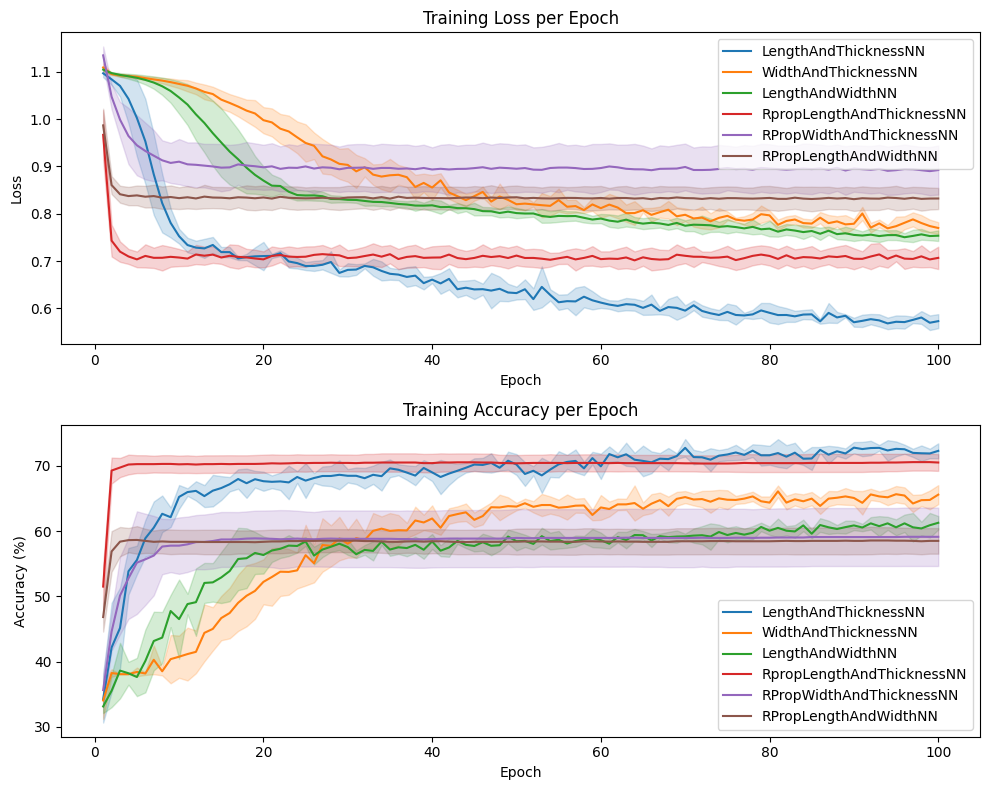

In [72]:
resultsWithoutHybrid = {}
with open("ResultsWithoutHybrid.json", "r") as f:
    resultsWithoutHybrid = json.load(f)
    
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

for model in resultsWithoutHybrid.keys():
    
    ax1.plot(range(1, numEpochs[0]+1), resultsWithoutHybrid[model]["avgTrainingLoss"], label=model)
    
    avgTrainingLoss = np.array(resultsWithoutHybrid[model]["avgTrainingLoss"])
    stdTrainingLoss = np.array(resultsWithoutHybrid[model]["stdTrainingLoss"])
    avgTrainingAcc = np.array(resultsWithoutHybrid[model]["avgTrainingAcc"])
    stdTrainingAcc = np.array(resultsWithoutHybrid[model]["stdTrainingAcc"])
    
    ax1.fill_between(range(1, numEpochs[0]+1), 
                     avgTrainingLoss - stdTrainingLoss, 
                     avgTrainingLoss + stdTrainingLoss, 
                     color=ax1.lines[-1].get_color(), alpha=0.2)
    ax1.set_title('Training Loss per Epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper right')
    ax1.grid()

    
    ax2.plot(range(1, numEpochs[0]+1), resultsWithoutHybrid[model]["avgTrainingAcc"], label=model)
    ax2.fill_between(range(1, numEpochs[0]+1), 
                     avgTrainingAcc - stdTrainingAcc, 
                     avgTrainingAcc + stdTrainingAcc, 
                     color=ax2.lines[-1].get_color(), alpha=0.2)
    ax2.set_title('Training Accuracy per Epoch')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend(loc='lower right')
    ax2.grid()


plt.tight_layout()
plt.savefig('resultsWithoutHybrid.png')
plt.show() 

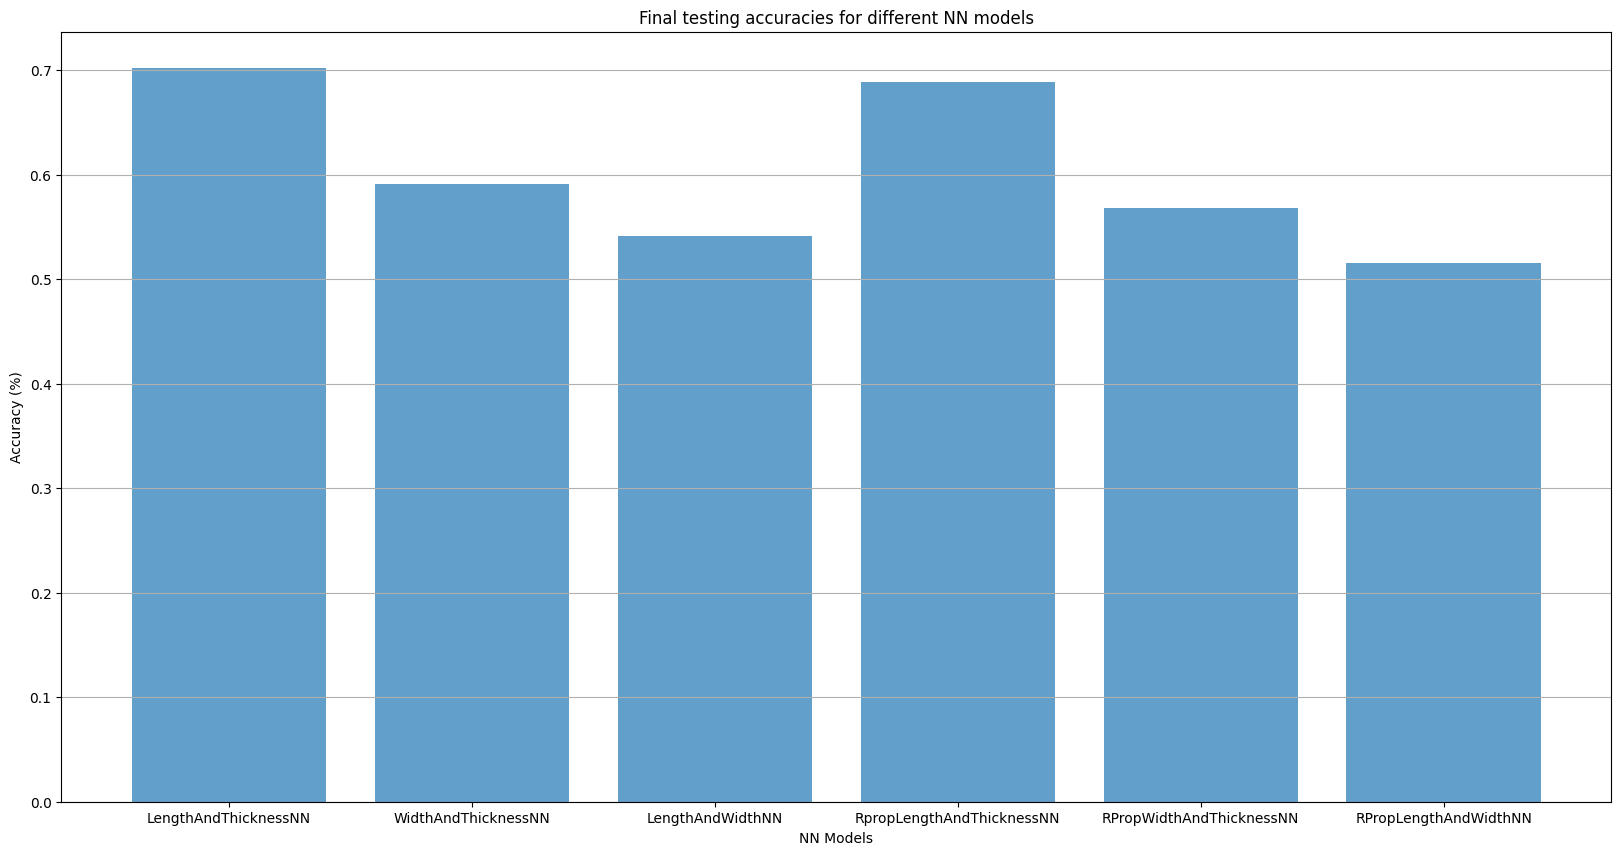

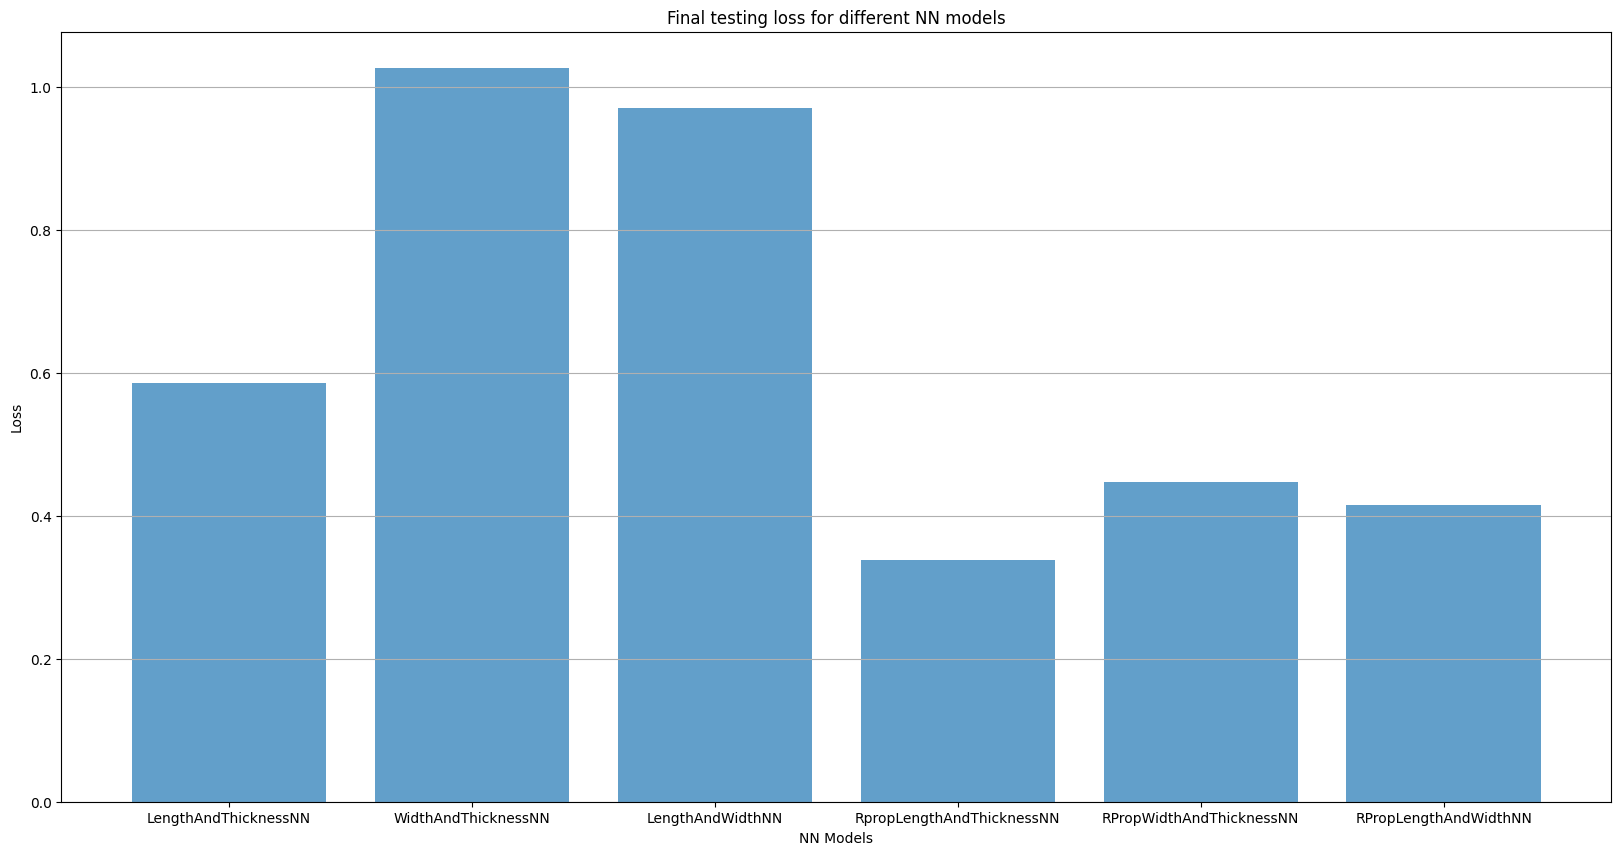

In [49]:
avgTestingAcc = []
avgTestingLoss = []
names = []
for model in resultsWithoutHybrid.keys():
    avgTestingLoss += [resultsWithoutHybrid[model]["avgTestingLoss"]]
    avgTestingAcc += [resultsWithoutHybrid[model]["avgTestingAcc"]]
    names += [model]

plt.figure(figsize=(20, 10))
plt.bar(names, avgTestingAcc, alpha=0.7) 
plt.title('Final testing accuracies for different NN models')
plt.xlabel('NN Models')
plt.ylabel('Accuracy (%)')
plt.grid(axis='y') 
plt.show() 

plt.figure(figsize=(20, 10))
plt.bar(names, avgTestingLoss, alpha=0.7)
plt.title('Final testing loss for different NN models')
plt.xlabel('NN Models')
plt.ylabel('Loss')
plt.grid(axis='y')
plt.show()

## Results with Hybrid Training

In [67]:
modelFunctions = [HTWidthAndThicknessNN,
                  HTLengthAndThicknessNN, HTLengthAndWidthNN]
modelFunctionsNames = ["HTWidthAndThicknessNN",
                       "HTLengthAndThicknessNN", "HTLengthAndWidthNN"]
seeds = [0, 8697, 9721, 4934, 12345]
numEpochs = [100, 100, 100]
learingRate = [0.1, 0.05, 0.1]

results = {}

for i in range(0, len(modelFunctions)):
    print("Starting with hybrid training of {}".format(modelFunctionsNames[i]))
    avgTrainingAccA, avgTrainingLossA, avgTestingAccA, avgTestingLossA, stdTrainingAccA, stdTrainingLossA, stdTestingAccA, stdTestingLossA, avgTrainingAccB, avgTrainingLossB, avgTestingAccB, avgTestingLossB, stdTrainingAccB, stdTrainingLossB, stdTestingAccB, stdTestingLossB = mrunsHT(
        modelFunctions[i], numEpochs[i], learingRate[i], seeds)
    results[modelFunctionsNames[i]] = {
        "avgTrainingAcc": avgTrainingAccA,
        "avgTrainingLoss": avgTrainingLossA,
        "avgTestingAcc": avgTestingAccA,
        "avgTestingLoss": avgTestingLossA,
        "stdTrainingAcc": stdTrainingAccA,
        "stdTrainingLoss": stdTrainingLossA,
        "stdTestingAcc": stdTestingAccA,
        "stdTestingLoss": stdTestingLossA,
    }
    results[modelFunctionsNames[i] + "RProp"] = {
        "avgTrainingAcc": avgTrainingAccB,
        "avgTrainingLoss": avgTrainingLossB,
        "avgTestingAcc": avgTestingAccB,
        "avgTestingLoss": avgTestingLossB,
        "stdTrainingAcc": stdTrainingAccB,
        "stdTrainingLoss": stdTrainingLossB,
        "stdTestingAcc": stdTestingAccB,
        "stdTestingLoss": stdTestingLossB,
    }

with open("ResultsWithHybrid.json", "w") as f:
    json.dump(results, f)
    print("Saved results to file")

Starting with hybrid training of HTWidthAndThicknessNN
Starting with hybrid training of HTLengthAndThicknessNN
Starting with hybrid training of HTLengthAndWidthNN
Saved results to file


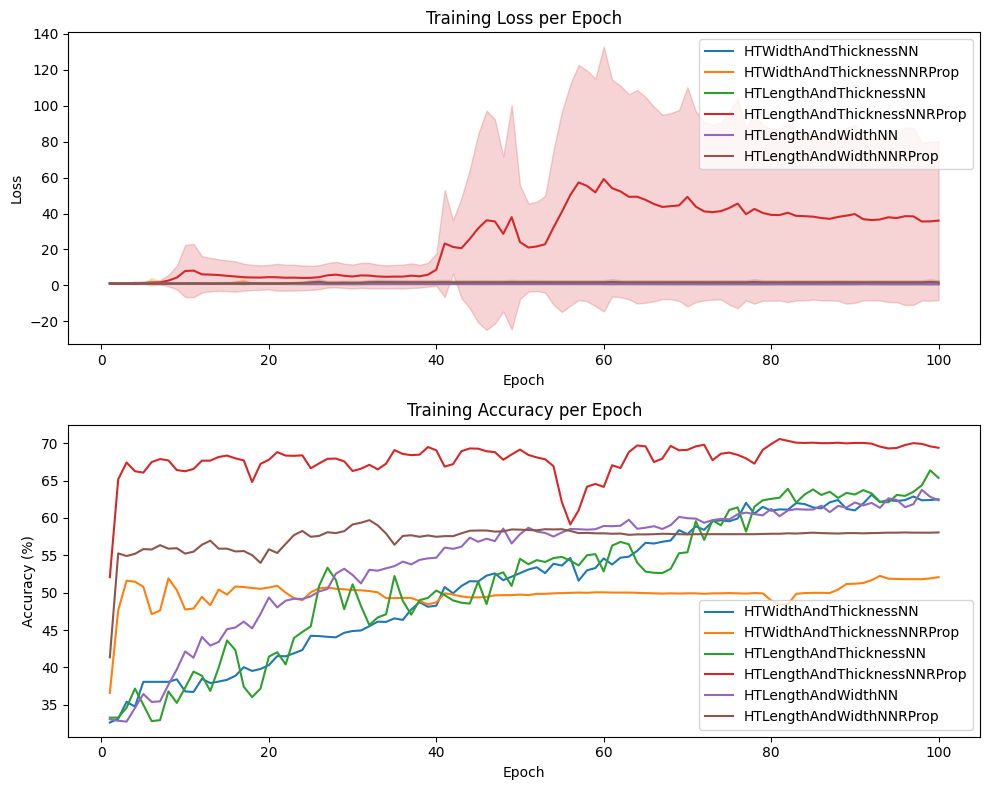

In [71]:
resultsWithHybrid = {}
with open("ResultsWithHybrid.json", "r") as f:
    resultsWithHybrid = json.load(f)
    
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

for model in resultsWithHybrid.keys():
    
    ax1.plot(range(1, numEpochs[0]+1), resultsWithHybrid[model]["avgTrainingLoss"], label=model)
    
    avgTrainingLoss = np.array(resultsWithHybrid[model]["avgTrainingLoss"])
    stdTrainingLoss = np.array(resultsWithHybrid[model]["stdTrainingLoss"])
    avgTrainingAcc = np.array(resultsWithHybrid[model]["avgTrainingAcc"])
    stdTrainingAcc = np.array(resultsWithHybrid[model]["stdTrainingAcc"])
    
    ax1.fill_between(range(1, numEpochs[0]+1), 
                     avgTrainingLoss - stdTrainingLoss, 
                     avgTrainingLoss + stdTrainingLoss, 
                     color=ax1.lines[-1].get_color(), alpha=0.2)
    ax1.set_title('Training Loss per Epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper right')
    ax1.grid()

    
    ax2.plot(range(1, numEpochs[0]+1), resultsWithoutHybrid[model]["avgTrainingAcc"], label=model)
    #ax2.fill_between(range(1, numEpochs[0]+1), 
    #                 avgTrainingAcc - stdTrainingAcc, 
    #                 avgTrainingAcc + stdTrainingAcc, 
    #                 color=ax2.lines[-1].get_color(), alpha=0.2)
    ax2.set_title('Training Accuracy per Epoch')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend(loc='lower right')
    ax2.grid()


plt.tight_layout()
plt.savefig('resultsWithHybrid.png')
plt.show()

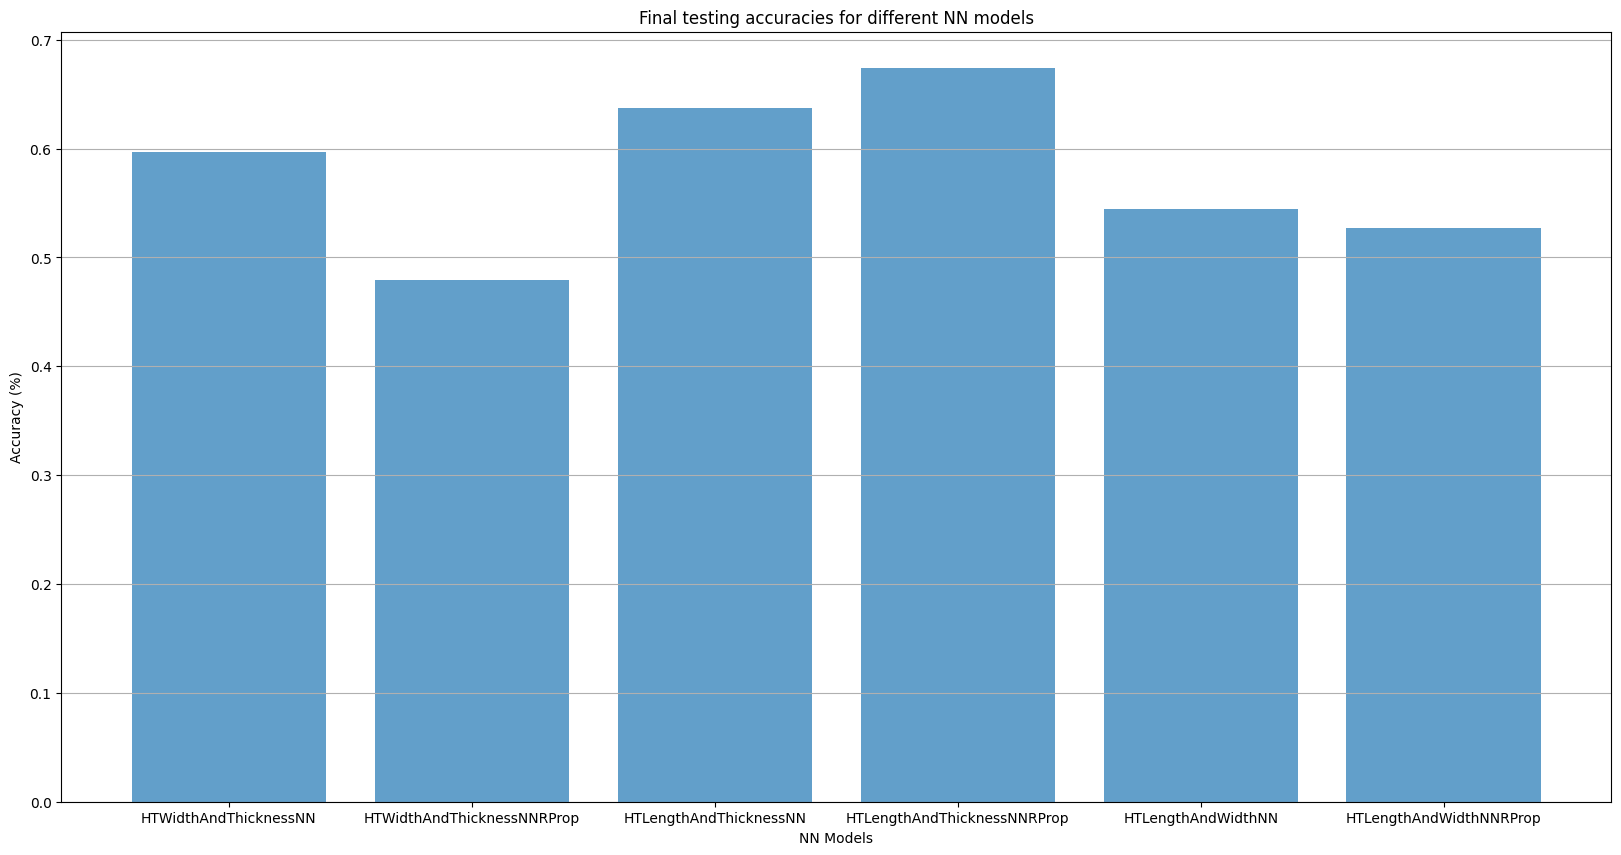

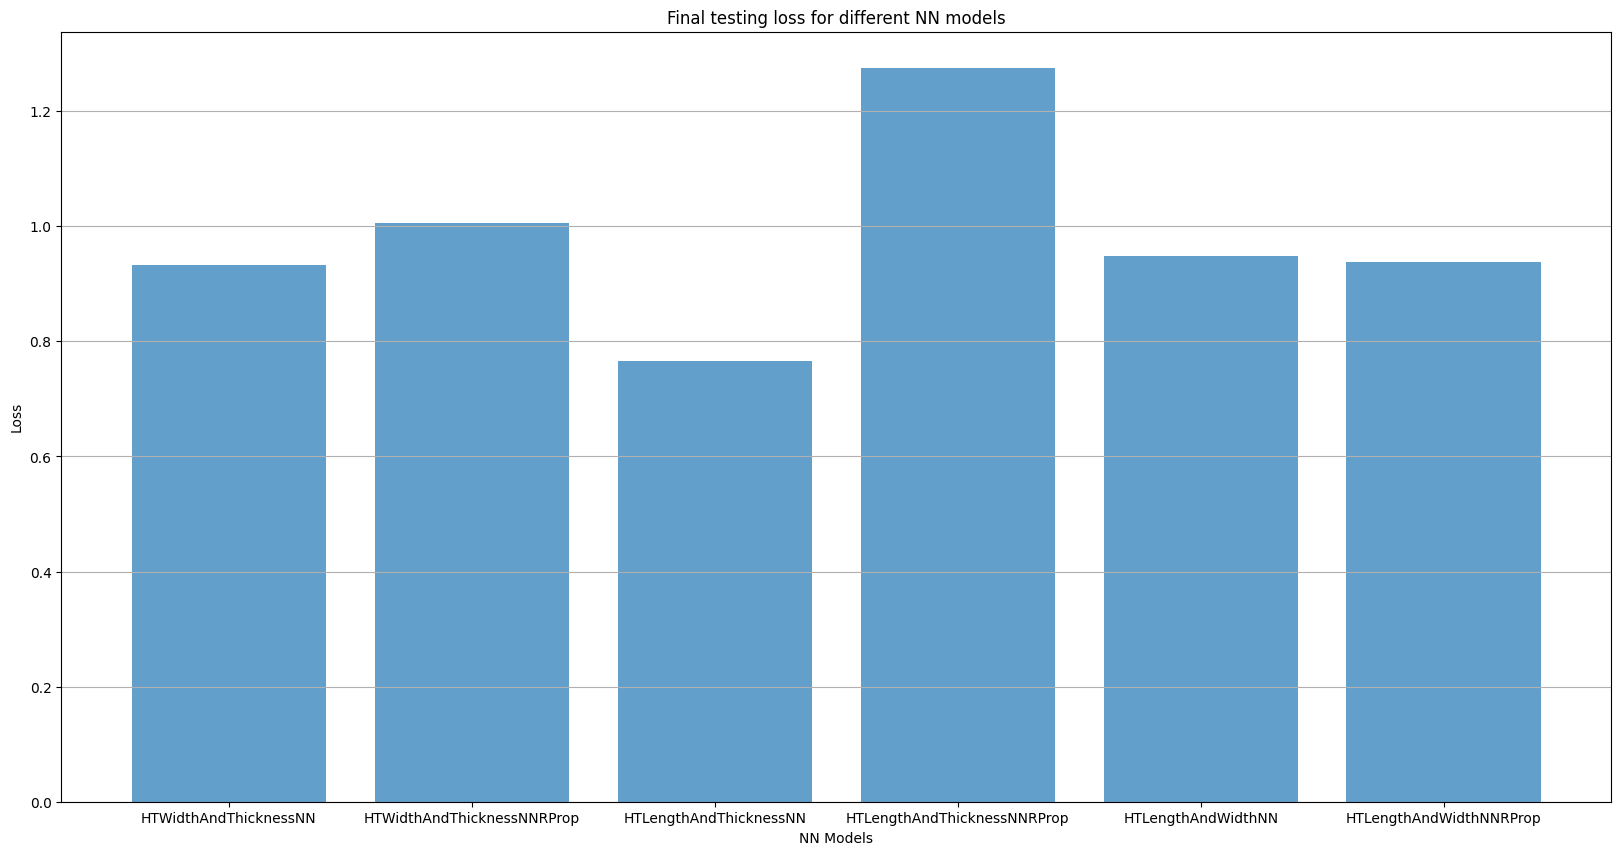

In [69]:
avgTestingAcc = []
avgTestingLoss = []
names = []
for model in resultsWithoutHybrid.keys():
    avgTestingLoss += [resultsWithoutHybrid[model]["avgTestingLoss"]]
    avgTestingAcc += [resultsWithoutHybrid[model]["avgTestingAcc"]]
    names += [model]

plt.figure(figsize=(20, 10))
plt.bar(names, avgTestingAcc, alpha=0.7)
plt.title('Final testing accuracies for different NN models')
plt.xlabel('NN Models')
plt.ylabel('Accuracy (%)')
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(20, 10))
plt.bar(names, avgTestingLoss, alpha=0.7)
plt.title('Final testing loss for different NN models')
plt.xlabel('NN Models')
plt.ylabel('Loss')
plt.grid(axis='y')
plt.show()